# Assignment:
In this Jupyter Notebook you find the answer to the asked question that follows:

<div style="border: 1px solid #ddd; border-radius: 5px; padding: 10px; background-color: #f9f9f9;">

With the data provided we would like to ask you to implement a ML classification model and provide the code necessary to train it from scratch. We are not asking for a model with any specific capabilities or performance, it is up to you to explore the problem and assess what could be reasonable and interesting within the given time constraints, taking design decisions accordingly. We'd like you to analyse the problem and give us some insights. The insights should be useful and actionable in some way.
    
We ask data scientist do want to join Idoven to work with anonymised patient data, and on the basis of this data be able to:

- Read the ECG files and corresponding annotations
- Show how they will work on the signal and plot the signal in appropriate manner to be read by a doctor
  
As a result we expect a github project with and extructure that will include:

- Reference documentation used
- **Jupyter Notebook** (this notebook), in an running environment, Colab, Docker.
- An explanation of the work done and lessons learned.

</div>
<br/><br/>

The structure of this Jupyter Notebook is as follow:
- **Exploratory Data Analysis (EDA)**: to understand the data and its properties (ECG files, signals, annotations, plots, data processing)
- **ML classification**: runnable script to train and evaluate the trained model. The code is provided as Jupyter Notebook which calls methods and modules from *.py* file to maintain verbosity on main actions
- **Conclusion**: discussion on the work done, lessons learned and possible future works. In this section a list of references is provided.  

In [1]:
data_path = '../data/ptbxl/'

## Exploratory Data Analysis (EDA)

#### Import libraries

In [2]:
import pandas as pd
import numpy as np
import os
import wfdb
import ast
import ecg_plot
from tqdm import tqdm
import warnings; warnings.filterwarnings('ignore')
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
## Defining functions as in example_physionet.py

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_lr)]
    else:
        data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_hr)]
    data = np.array([signal for signal, meta in data])
    return data

In [4]:
# path = '/content/drive/MyDrive/ModelData/data/ptbxl/' -- get dataset from mounted drive account (relatively slow)
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(data_path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, data_path)


100%|██████████| 21837/21837 [00:42<00:00, 508.88it/s]


### Analyse CSVs


#### Annotation data
CSV file with patient's information, annotations and metadata

In [5]:
# Total number of rows and columns
print(f"Training Set:\nNumber of Rows: {Y.shape[0]}, Number of Columns: {Y.shape[1]}")
Y.head()

Training Set:
Number of Rows: 21837, Number of Columns: 27


patient_id   age  sex  height  weight  nurse  site     device  \
ecg_id                                                                  
1          15709.0  56.0    1     NaN    63.0    2.0   0.0  CS-12   E   
2          13243.0  19.0    0     NaN    70.0    2.0   0.0  CS-12   E   
3          20372.0  37.0    1     NaN    69.0    2.0   0.0  CS-12   E   
4          17014.0  24.0    0     NaN    82.0    2.0   0.0  CS-12   E   
5          17448.0  19.0    1     NaN    70.0    2.0   0.0  CS-12   E   

             recording_date                                  report  ...  \
ecg_id                                                               ...   
1       1984-11-09 09:17:34  sinusrhythmus periphere niederspannung  ...   
2       1984-11-14 12:55:37     sinusbradykardie sonst normales ekg  ...   
3       1984-11-15 12:49:10              sinusrhythmus normales ekg  ...   
4       1984-11-15 13:44:57              sinusrhythmus normales ekg  ...   
5       1984-11-17 10:43:15              sinusrhythmus normales ekg  ...   

       validated_by_human  baseline_drift static_noise burst_noise  \
ecg_id                                                               
1                    True             NaN    , I-V1,           NaN   
2                    True             NaN          NaN         NaN   
3                    True             NaN          NaN         NaN   
4                    True    , II,III,AVF          NaN         NaN   
5                    True   , III,AVR,AVF          NaN         NaN   

        electrodes_problems  extra_beats  pacemaker  strat_fold  \
ecg_id                                                            
1                       NaN          NaN        NaN           3   
2                       NaN          NaN        NaN           2   
3                       NaN          NaN        NaN           5   
4                       NaN          NaN        NaN           3   
5                       NaN          NaN        NaN           4   

                      filename_lr                filename_hr  
ecg_id                                                        
1       records100/00000/00001_lr  records500/00000/00001_hr  
2       records100/00000/00002_lr  records500/00000/00002_hr  
3       records100/00000/00003_lr  records500/00000/00003_hr  
4       records100/00000/00004_lr  records500/00000/00004_hr  
5       records100/00000/00005_lr  records500/00000/00005_hr  

[5 rows x 27 columns]

In [6]:
Y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21837 entries, 1 to 21837
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21837 non-null  float64
 1   age                           21748 non-null  float64
 2   sex                           21837 non-null  int64  
 3   height                        6983 non-null   float64
 4   weight                        9429 non-null   float64
 5   nurse                         20328 non-null  float64
 6   site                          21819 non-null  float64
 7   device                        21837 non-null  object 
 8   recording_date                21837 non-null  object 
 9   report                        21837 non-null  object 
 10  scp_codes                     21837 non-null  object 
 11  heart_axis                    13332 non-null  object 
 12  infarction_stadium1           5626 non-null   object 
 13  infarc

We have 27 columns with different data types. We can see that there are null values for several columns (we'll look at it later)


**Descriptive Analysis**

In [7]:
print("Dataset Descriptive Analysis for numerical values.")
Y.describe().transpose()

Dataset Descriptive Analysis for numerical values.


count          mean          std    min     25%      50%  \
patient_id    21837.0  11255.005953  6234.132489  302.0  5982.0  11423.0   
age           21748.0     59.836307    16.953125    2.0    50.0     62.0   
sex           21837.0      0.478912     0.499567    0.0     0.0      0.0   
height         6983.0    166.708292    10.864935    6.0   160.0    166.0   
weight         9429.0     70.997561    15.875146    5.0    60.0     70.0   
nurse         20328.0      2.292503     3.254786    0.0     0.0      1.0   
site          21819.0      1.547229     4.169753    0.0     0.0      1.0   
validated_by  12426.0      0.747948     1.183269    0.0     0.0      1.0   
strat_fold    21837.0      5.505335     2.875306    1.0     3.0      6.0   

                  75%      max  
patient_id    16614.0  21797.0  
age              72.0     95.0  
sex               1.0      1.0  
height          174.0    209.0  
weight           80.0    250.0  
nurse             3.0     11.0  
site              2.0     50.0  
validated_by      1.0     11.0  
strat_fold        8.0     10.0

We can see that, as anticipated by the README.md in folder **data** male and female are almost the same percentage (balanced).\
The mean age is ~60 yo. with a std ~16, and the median value is 62yo.\
The height and weight have several missing values.

**Missing values**

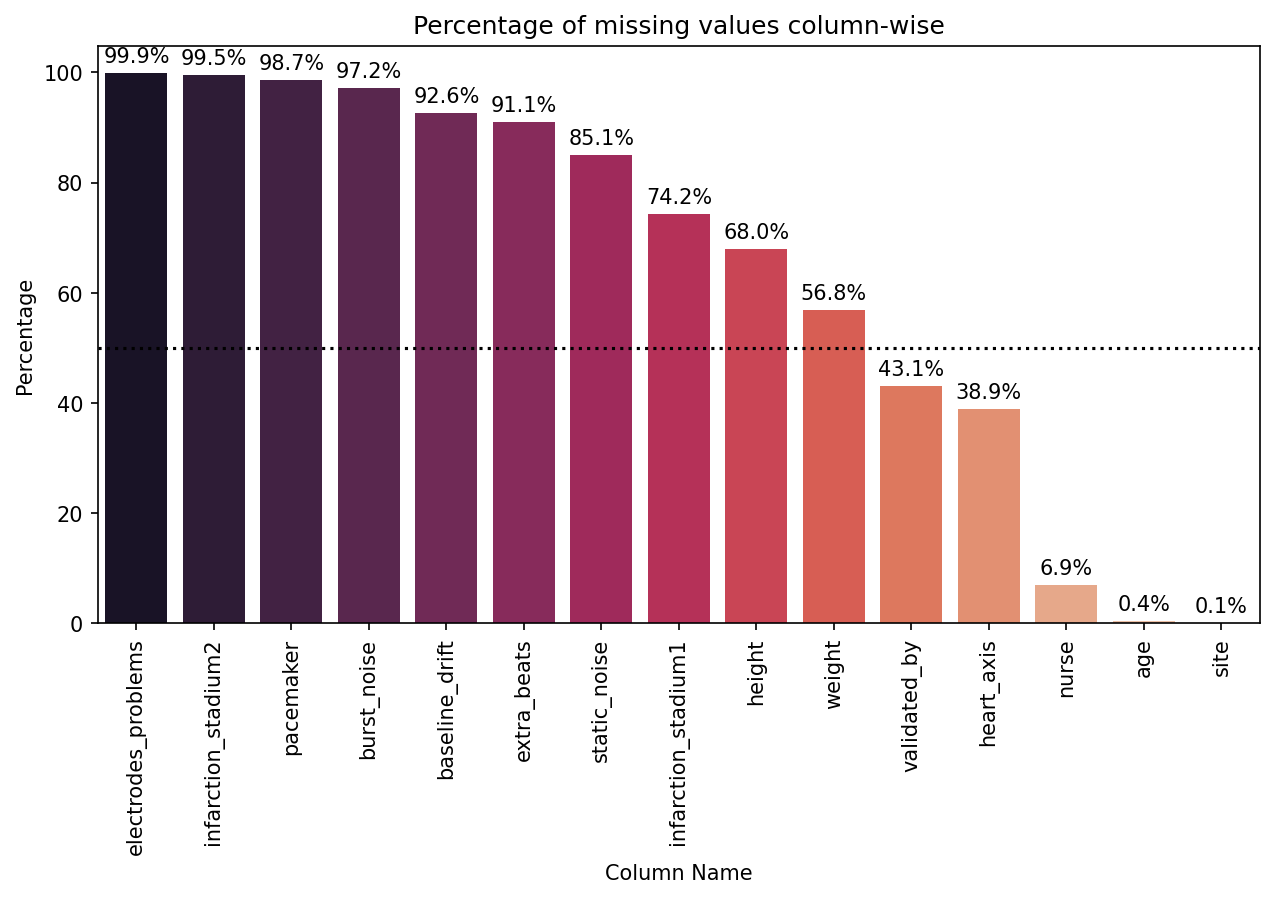

In [8]:
# Calculate percentage of missing values
null_values = Y.isnull().sum().sort_values(ascending=False)
percent = (Y.isnull().sum() / len(Y)) * 100
percent = percent[percent > 0].sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10,5 ), dpi=150)
ax = sns.barplot(x=percent.index, y=percent, palette="rocket")

# Add percentage values above the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center',
                xytext=(0, 8), textcoords='offset points')

# Add horizontal dotted line at y=50
plt.axhline(50, color='black', linestyle='dotted')

# Set axis labels
plt.xlabel('Column Name')
plt.ylabel('Percentage')
plt.title('Percentage of missing values column-wise')
# Rotate x-axis labels
plt.xticks(rotation=90)

# Display the plot
plt.show()


**Correlations**

Pearson's correlation to check linear correletion among numerical variables.

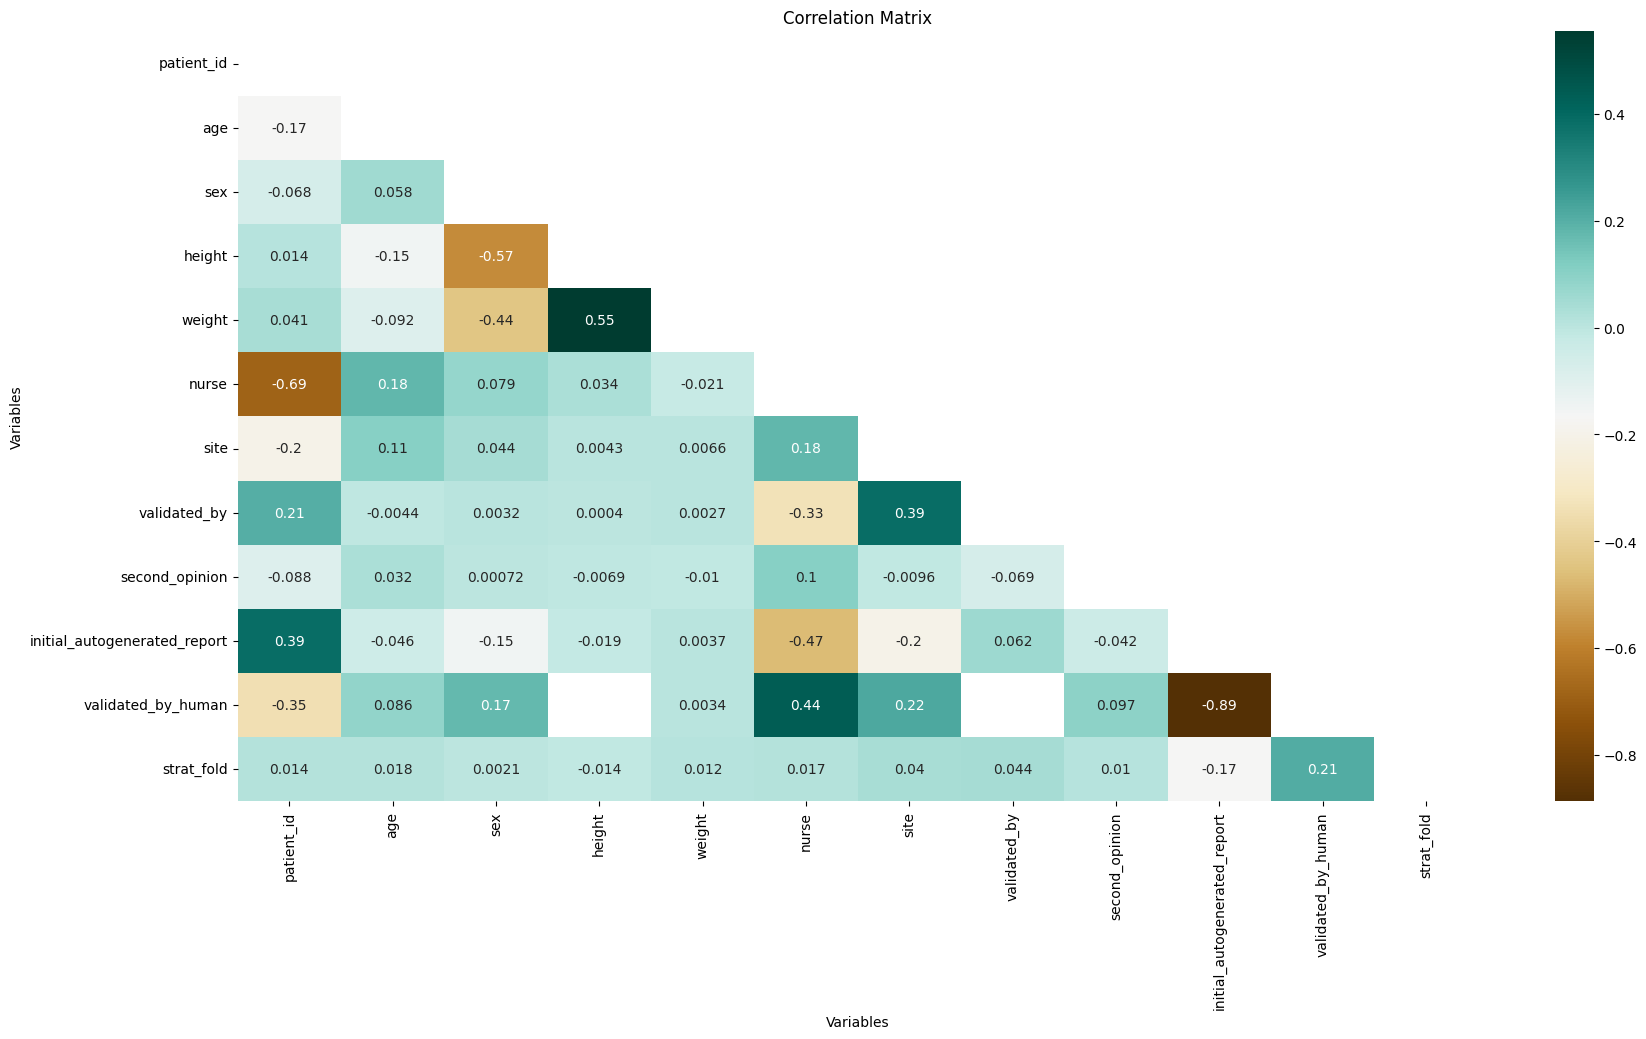

In [9]:
# Convert appropriate columns to numeric, using errors='coerce' to handle errors
Y_numeric = Y.apply(pd.to_numeric, errors='coerce')

# Drop columns that were fully converted to NaN due to non-numeric values
Y_numeric = Y_numeric.dropna(axis=1, how='all')

# Compute the correlation matrix
corr_matrix = Y_numeric.corr()

# Mask to only show upper triangle
mask = np.triu(corr_matrix)

# Plotting the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, cmap="BrBG", annot=True, mask=mask)
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.title('Correlation Matrix')
plt.show()

Considering the correlation of clinical metadata (such as *age, sex, weight* and *height*) we can see that height and weight are negative linearly correlated with *gender* variable (male are encoded as 0 and female as 1). This negative correlation between gender-height and gender-weigth suggests that males are, on average, taller and heavier than females. On the other hand, there is a positive linear correlation between height and weight that suggest that, on average, taller patients are also heavier.

#### Diagnostic Data
Load *scp_statements.csv*, explore the diagnostic values and perform aggregation.

In [10]:
# Load 
state_df = pd.read_csv(data_path+'scp_statements.csv', index_col=0)
print(f"Loaded dataset length: {len(state_df)}")
diag_df = state_df[state_df.diagnostic == 1] # keep value with diagnostic
print(f"Diagnosis in dataset: {len(diag_df)}")
diag_df.head()

Loaded dataset length: 71
Diagnosis in dataset: 44


description  diagnostic  form  rhythm  \
NDT    non-diagnostic T abnormalities         1.0   1.0     NaN   
NST_          non-specific ST changes         1.0   1.0     NaN   
DIG                  digitalis-effect         1.0   1.0     NaN   
LNGQT                long QT-interval         1.0   1.0     NaN   
NORM                       normal ECG         1.0   NaN     NaN   

      diagnostic_class diagnostic_subclass  \
NDT               STTC                STTC   
NST_              STTC                NST_   
DIG               STTC                STTC   
LNGQT             STTC                STTC   
NORM              NORM                NORM   

                                      Statement Category  \
NDT                    other ST-T descriptive statements   
NST_   Basic roots for coding ST-T changes and abnorm...   
DIG                    other ST-T descriptive statements   
LNGQT                  other ST-T descriptive statements   
NORM                                     Normal/abnormal   

        SCP-ECG Statement Description  AHA code            aECG REFID  \
NDT    non-diagnostic T abnormalities       NaN                   NaN   
NST_          non-specific ST changes     145.0  MDC_ECG_RHY_STHILOST   
DIG         suggests digitalis-effect     205.0                   NaN   
LNGQT                long QT-interval     148.0                   NaN   
NORM                       normal ECG       1.0                   NaN   

      CDISC Code DICOM Code  
NDT          NaN        NaN  
NST_         NaN        NaN  
DIG          NaN        NaN  
LNGQT        NaN        NaN  
NORM         NaN    F-000B7

In [11]:
print(f"{diag_df.diagnostic_class.nunique()} unique values for diagnostic_class: {(diag_df.diagnostic_class.unique())}")
print(f"{diag_df.diagnostic_subclass.nunique()} unique values for diagnostic_subclass: {(diag_df.diagnostic_subclass.unique())}")


5 unique values for diagnostic_class: ['STTC' 'NORM' 'MI' 'HYP' 'CD']
23 unique values for diagnostic_subclass: ['STTC' 'NST_' 'NORM' 'IMI' 'AMI' 'LVH' 'LAFB/LPFB' 'ISC_' 'IRBBB' '_AVB'
 'IVCD' 'ISCA' 'CRBBB' 'CLBBB' 'LAO/LAE' 'ISCI' 'LMI' 'RVH' 'RAO/RAE'
 'WPW' 'ILBBB' 'SEHYP' 'PMI']


We can see that there are the 5 *diagnostic_classes* as described in the problem statement, and 23 subclasses. Let's aggregate them in the annotation dataframe.

#### Aggregate diagnostic data with annotation data

Aggregate the information and then analyze the distribution onf variables wrt diagnosis.

**Diagnostic Superclass**

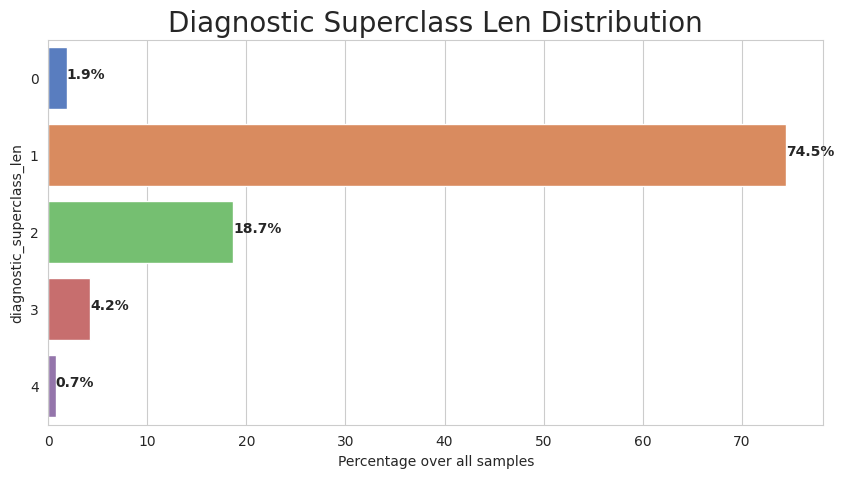

In [12]:
def aggregate_supclass_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in diag_df.index:
            tmp.append(diag_df.loc[key].diagnostic_class)
    return list(set(tmp))
    
# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_supclass_diagnostic)
Y['diagnostic_superclass_len'] = Y['diagnostic_superclass'].apply(len)
Y.loc[Y.diagnostic_superclass_len > 1, 'diagnostic_superclass']

## Now plot the percentage len among sample

vc = Y['diagnostic_superclass_len'].value_counts()

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(x=vc.values/vc.values.sum()*100., y=vc.index, ci=None, palette="muted",orient='h' )
ax.set_title("Diagnostic Superclass Len Distribution", fontsize=20)
ax.set_xlabel ("Percentage over all samples")
ax.set_ylabel ("diagnostic_superclass_len")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

**Diagnosti Subclass**

Do the same for subclasses

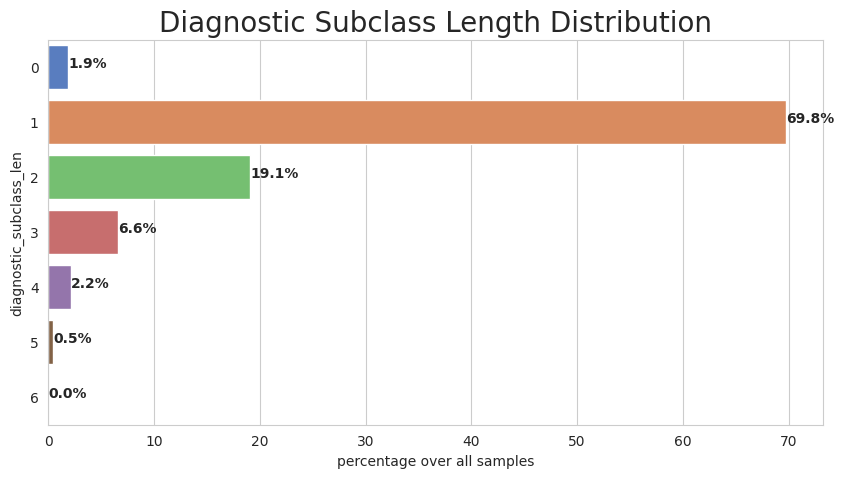

In [13]:
def aggregate_subclass_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in diag_df.index:
            tmp.append(diag_df.loc[key].diagnostic_subclass)
    ret = list(set(tmp))
    ret = ['sub_'+r for r in ret] # to distinguish between subclass and superclass columns
    return ret

# Apply diagnostic subclass
Y['diagnostic_subclass'] = Y.scp_codes.apply(aggregate_subclass_diagnostic)
Y['diagnostic_subclass_len'] = Y['diagnostic_subclass'].apply(len)
Y.loc[Y.diagnostic_subclass_len > 1, 'diagnostic_subclass']

vc = Y['diagnostic_subclass_len'].value_counts()

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(x=vc.values/vc.values.sum()*100., y=vc.index, ci=None, palette="muted",orient='h' )
ax.set_title("Diagnostic Subclass Length Distribution", fontsize=20)
ax.set_xlabel ("percentage over all samples")
ax.set_ylabel ("diagnostic_subclass_len")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

#### Distribution analysis

In [14]:
## Functions
class ClassUpdate():
    def __init__(self, cols):
        self.cols = cols

    def __call__(self, row):
        for sc in row['diagnostic_superclass']:
            row[sc] = 1
        for sc in row['diagnostic_subclass']:
            row[sc] = 1
            
        return row

def get_data_by_folds(folds, x, y, update_cols, feature_cols):
    assert len(folds)  > 0, '# of provided folds should longer than 1'
    #print(y.strat_fold)
    filt = np.isin(y.strat_fold.values, folds)
    x_selected = x[filt]
    y_selected = y[filt]
    
    for sc in update_cols:
        y_selected[sc] = 0
        
    cls_updt = ClassUpdate(update_cols)
    
    y_selected = y_selected.apply(cls_updt, axis=1)
    
    return x_selected, y_selected[list(feature_cols)+list(update_cols)+['strat_fold']]


In [15]:
all_superclass = pd.Series(np.concatenate(Y['diagnostic_superclass'].values))
superclass_cols = all_superclass.unique()
all_subclass = pd.Series(np.concatenate(Y['diagnostic_subclass'].values))
subclass_cols = all_subclass.unique()
update_cols = np.concatenate([superclass_cols, subclass_cols]) # concatenate subclass and superclass

meta_cols = ['age', 'sex', 'height', 'weight'] # add more columns as features


In [16]:
x_all, y_all = get_data_by_folds(np.arange(1, 11), X, Y, update_cols, meta_cols)
y_all.head()

age  sex  height  weight  NORM  MI  STTC  HYP  CD  sub_NORM  ...  \
ecg_id                                                                ...   
1       56.0    1     NaN    63.0     1   0     0    0   0         1  ...   
2       19.0    0     NaN    70.0     1   0     0    0   0         1  ...   
3       37.0    1     NaN    69.0     1   0     0    0   0         1  ...   
4       24.0    0     NaN    82.0     1   0     0    0   0         1  ...   
5       19.0    1     NaN    70.0     1   0     0    0   0         1  ...   

        sub_ISC_  sub_SEHYP  sub_ISCI  sub_CRBBB  sub_CLBBB  sub_LAO/LAE  \
ecg_id                                                                     
1              0          0         0          0          0            0   
2              0          0         0          0          0            0   
3              0          0         0          0          0            0   
4              0          0         0          0          0            0   
5              0          0         0          0          0            0   

        sub_ILBBB  sub_WPW  sub_PMI  strat_fold  
ecg_id                                           
1               0        0        0           3  
2               0        0        0           2  
3               0        0        0           5  
4               0        0        0           3  
5               0        0        0           4  

[5 rows x 33 columns]

**Superclass distribution**

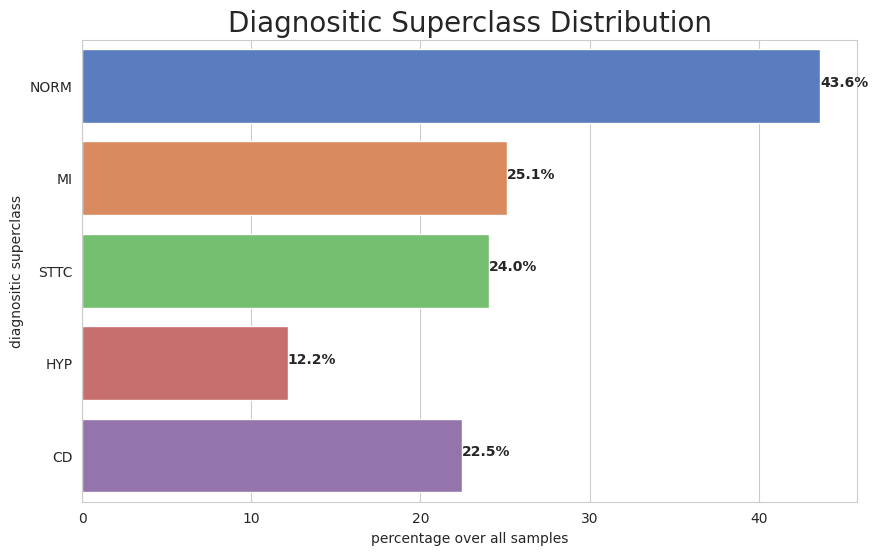

In [17]:
vc = y_all[superclass_cols].sum(axis=0)

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=vc.values/y_all.shape[0]*100., y=vc.index, ci=None, palette="muted",orient='h' )
ax.set_title("Diagnositic Superclass Distribution", fontsize=20)
ax.set_xlabel ("percentage over all samples")
ax.set_ylabel ("diagnositic superclass")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

**Subclass distribution**

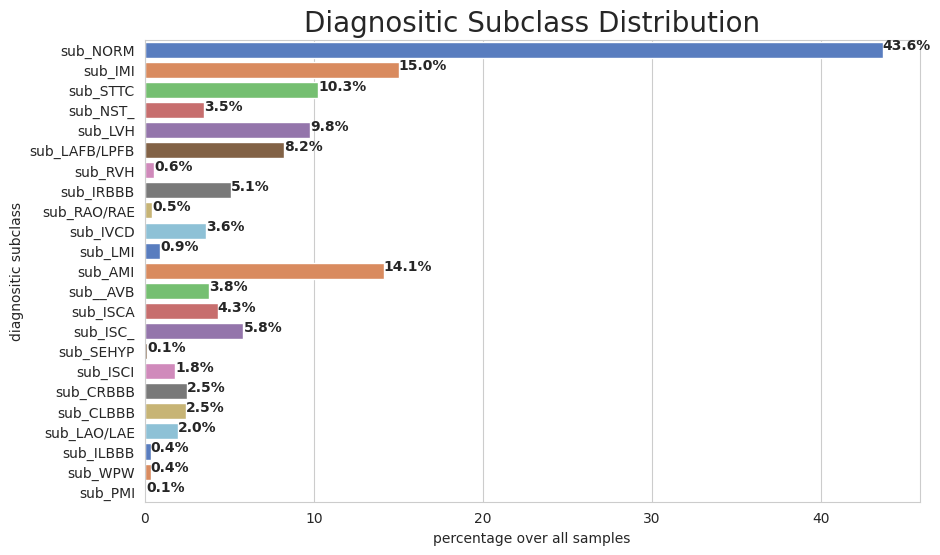

In [18]:
vc = y_all[subclass_cols].sum(axis=0)

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=vc.values/y_all.shape[0]*100., y=vc.index, ci=None, palette="muted",orient='h' )
ax.set_title("Diagnositic Subclass Distribution", fontsize=20)
ax.set_xlabel ("percentage over all samples")
ax.set_ylabel ("diagnositic subclass")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )
    

**Subclass distribution within superclass**

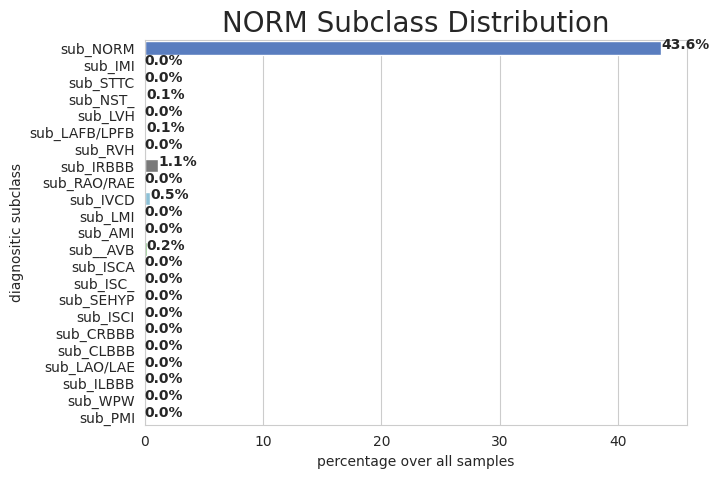

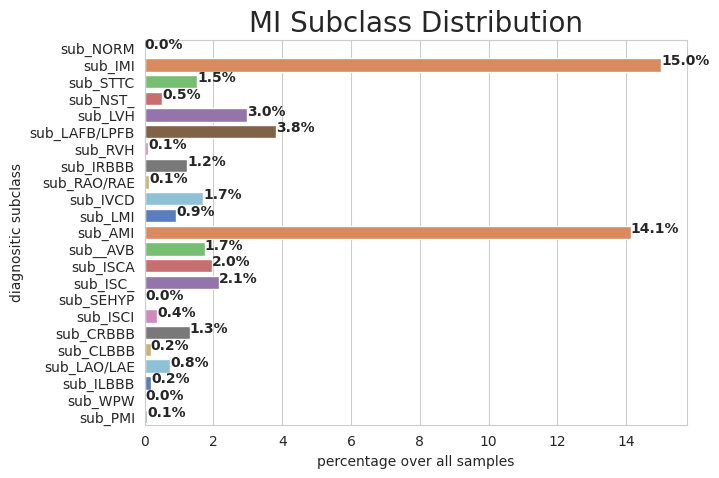

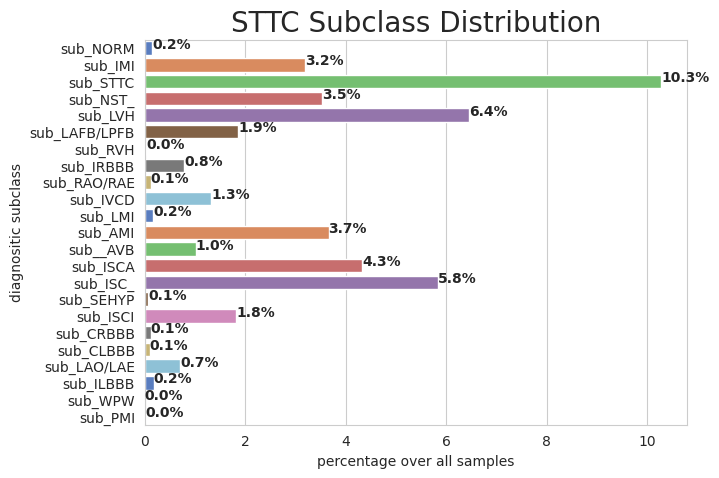

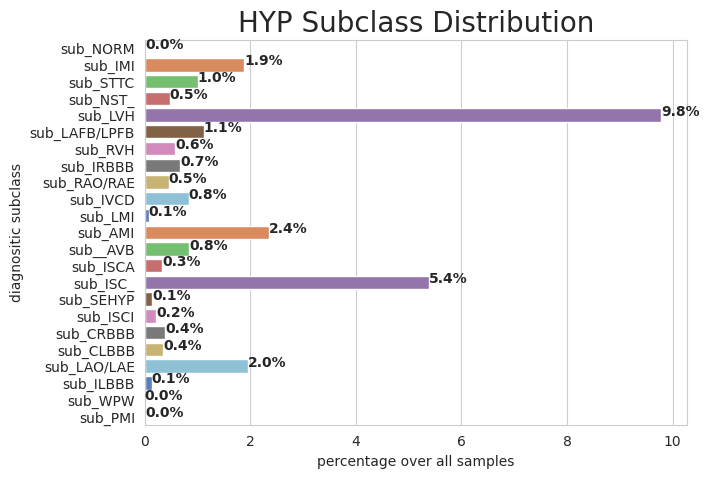

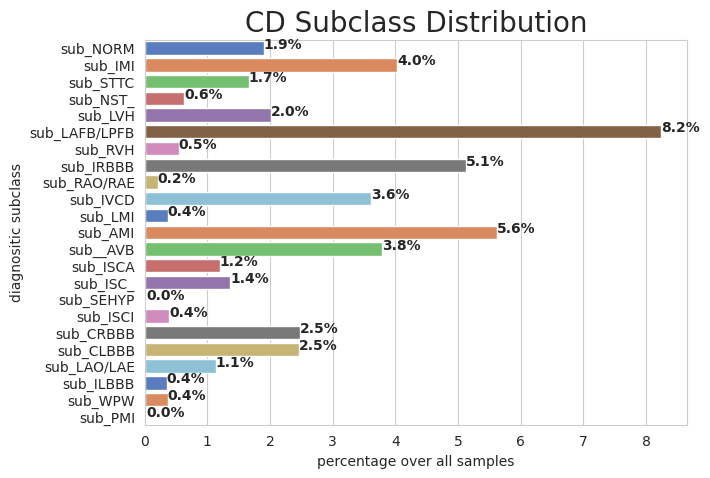

In [19]:
for superclass in superclass_cols:
    
    vc = y_all.loc[y_all[superclass] == 1][subclass_cols].sum(axis=0)
    
    sns.set_style("whitegrid")
    bar,ax = plt.subplots(figsize=(7,5))
    ax = sns.barplot(x=vc.values/y_all.shape[0]*100., y=vc.index, ci=None, palette="muted",orient='h' )
    ax.set_title("{} Subclass Distribution".format(superclass), fontsize=20)
    ax.set_xlabel ("percentage over all samples")
    ax.set_ylabel ("diagnositic subclass")
    for rect in ax.patches:
        ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

**Vabiable distributions among superclasses**

 - **Numerical variables**

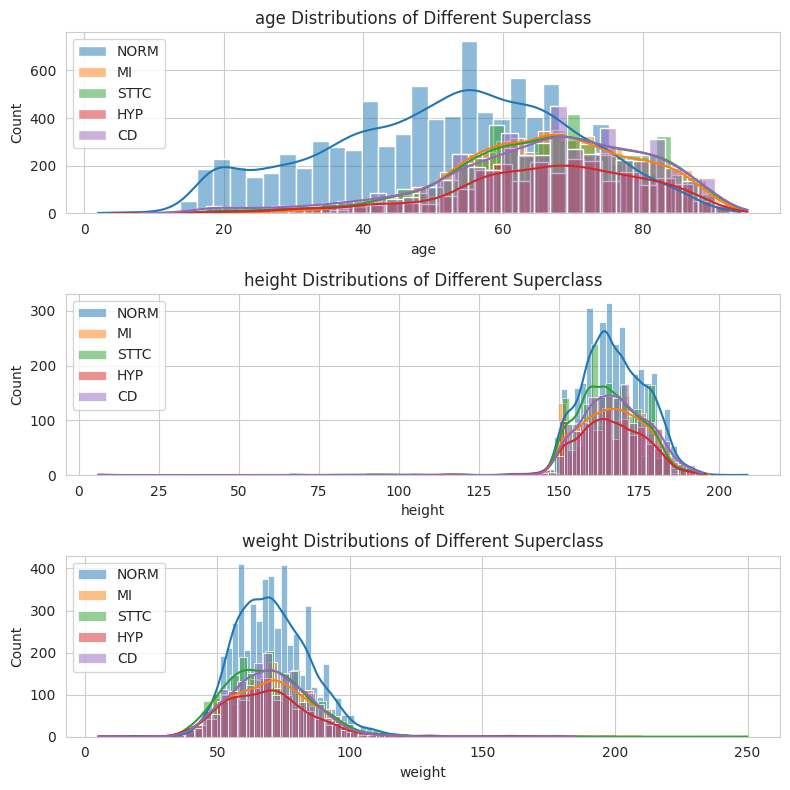

In [20]:
variables_to_plot = ['age', 'height', 'weight']
fig, axes = plt.subplots(len(variables_to_plot), 1, figsize=(8, 8))  # Adjust the figsize for better spacing

for i, variable in enumerate(variables_to_plot):
    axes[i].set_title(f'{variable} Distributions of Different Superclass')
    
    for superclass in superclass_cols:
        data = y_all.loc[y_all[superclass] == 1][variable]   
        sns.histplot(data, label=superclass, kde=True, ax=axes[i])
    
    axes[i].legend(loc='upper left')

plt.tight_layout()
plt.show()

The weight and height distributions appear visually similar across different superclasses. However, the age distribution for the NORM superclass seems slightly left-skewed. To assess the statistical significance of these observations, we can perform statistical tests such as the Kolmogorov-Smirnov (KS) test or t-tests. Additionally, other appropriate tests include the Mann-Whitney U test for non-parametric data, ANOVA for comparing means across multiple groups, and the Chi-square test for categorical variables.

In [21]:
from scipy.stats import ks_2samp, ttest_ind, mannwhitneyu

# Remove rows with NaN values for the relevant variables
y_all_cleaned = y_all.dropna(subset=variables_to_plot + list(superclass_cols))

# Performing statistical tests
for variable in variables_to_plot:
    print(f'\nStatistical tests for {variable}:')

    superclass_pairs = [(superclass_cols[i], superclass_cols[j]) 
                        for i in range(len(superclass_cols)) 
                        for j in range(i + 1, len(superclass_cols))]
    
    for pair in superclass_pairs:
        data1 = y_all_cleaned.loc[y_all_cleaned[pair[0]] == 1][variable]
        data2 = y_all_cleaned.loc[y_all_cleaned[pair[1]] == 1][variable]
        
        ks_stat, ks_p_value = ks_2samp(data1, data2)
        ttest_stat, ttest_p_value = ttest_ind(data1, data2)
        mannwhitney_stat, mannwhitney_p_value = mannwhitneyu(data1, data2)
        
        print(f'{pair[0]} vs {pair[1]}:')
        print(f'  KS test: stat={ks_stat:.4f}, p-value={ks_p_value:.4e}')
        print(f'  t-test: stat={ttest_stat:.4f}, p-value={ttest_p_value:.4e}')
        print(f'  Mann-Whitney U test: stat={mannwhitney_stat:.4f}, p-value={mannwhitney_p_value:.4e}')



Statistical tests for age:
NORM vs MI:
  KS test: stat=0.4113, p-value=1.5091e-142
  t-test: stat=-30.9426, p-value=1.1141e-190
  Mann-Whitney U test: stat=946237.5000, p-value=7.4895e-186
NORM vs STTC:
  KS test: stat=0.3862, p-value=3.1863e-153
  t-test: stat=-31.6726, p-value=1.2402e-200
  Mann-Whitney U test: stat=1391398.5000, p-value=9.1662e-197
NORM vs HYP:
  KS test: stat=0.3991, p-value=5.2000e-108
  t-test: stat=-25.2872, p-value=2.6434e-131
  Mann-Whitney U test: stat=746018.0000, p-value=1.2644e-135
NORM vs CD:
  KS test: stat=0.3750, p-value=1.6104e-126
  t-test: stat=-27.0739, p-value=5.7842e-150
  Mann-Whitney U test: stat=1193861.5000, p-value=3.4318e-157
MI vs STTC:
  KS test: stat=0.0410, p-value=1.4610e-01
  t-test: stat=2.5424, p-value=1.1056e-02
  Mann-Whitney U test: stat=1245953.5000, p-value=9.2140e-02
MI vs HYP:
  KS test: stat=0.0342, p-value=5.0556e-01
  t-test: stat=1.6987, p-value=8.9510e-02
  Mann-Whitney U test: stat=671052.5000, p-value=5.0941e-01
MI vs

So, as noticed visually the NORM vs other classes for Age distributions resulted in:
- NORM vs MI:
  - Mann-Whitney U test: stat=946237.5000, p-value=7.4895e-186
- NORM vs STTC:
  - Mann-Whitney U test: stat=1391398.5000, p-value=9.1662e-197
- NORM vs HYP:
  - Mann-Whitney U test: stat=746018.0000, p-value=1.2644e-135
- NORM vs CD:
  - Mann-Whitney U test: stat=1193861.5000, p-value=3.4318e-157

all have a p-value < 0.005 which means that the differences between distribution has statistical significance and cannot be assessed only to randomness.

- **Categorical variables**

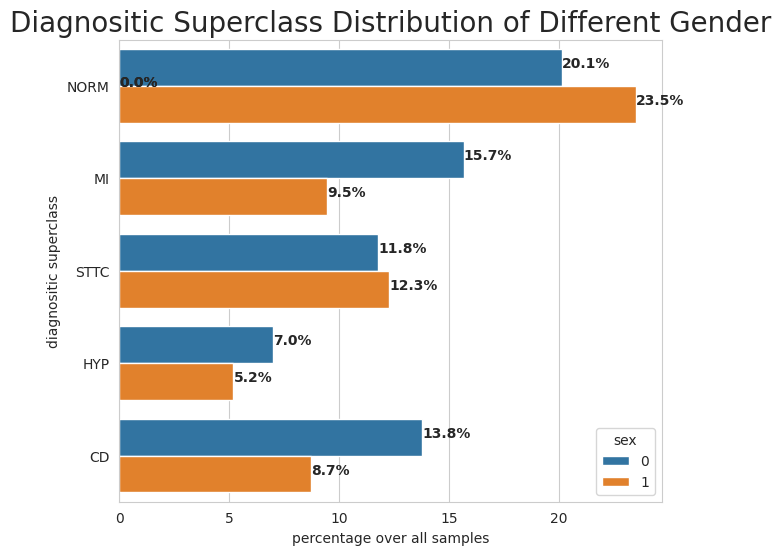

In [22]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(7,6))
    
ax.set_title("Diagnositic Superclass Distribution of Different Gender", fontsize=20)

all_index, all_count, all_values = [], [], []
for sex in y_all.sex.unique():
    vc = y_all.loc[y_all.sex == sex][superclass_cols].sum(axis=0)
    all_index += list(vc.index)
    all_count += list(vc.values/y_all.shape[0]*100.)
    all_values += [sex]*len(vc)
    #print(all_sex)
    
df = pd.DataFrame()
df['diagnositic superclass'] = all_index
df['percentage over all samples'] = all_count
df['sex'] = all_values
    
ax = sns.barplot(data=df, x="percentage over all samples", y="diagnositic superclass", hue="sex",ci=None, orient='h')
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold')

Again, here we can perform Chi-square test for categorical variables to asses the comparison among distributions. 

In [23]:
del X, Y
import gc
# Perform garbage collection
gc.collect()


38115

### Display ECG and pre-processing steps

To reduce verbosity and make it clear, in this section external function are used to load, aggregate and process data as explained in the previous subsections.

In [24]:
import data.dataloader as dataloader
from data import data_plots
import data.signal_data_processing as signal_processor


In [25]:
# Load the data
data_path = '../data/ptbxl/'
data = dataloader.load_data(data_path= data_path,
                       sampling_rate=100)
print("\nData loaded.\n")


Data loaded.



**Access patient's data**: Display the ECG with diagnosis and metadata to be read by medical doctors. 

In [26]:
# annotations = data['train']['annotations']
# [(annotations.strat_fold <= 8)]

Patient 13243 has 1 ECGs.


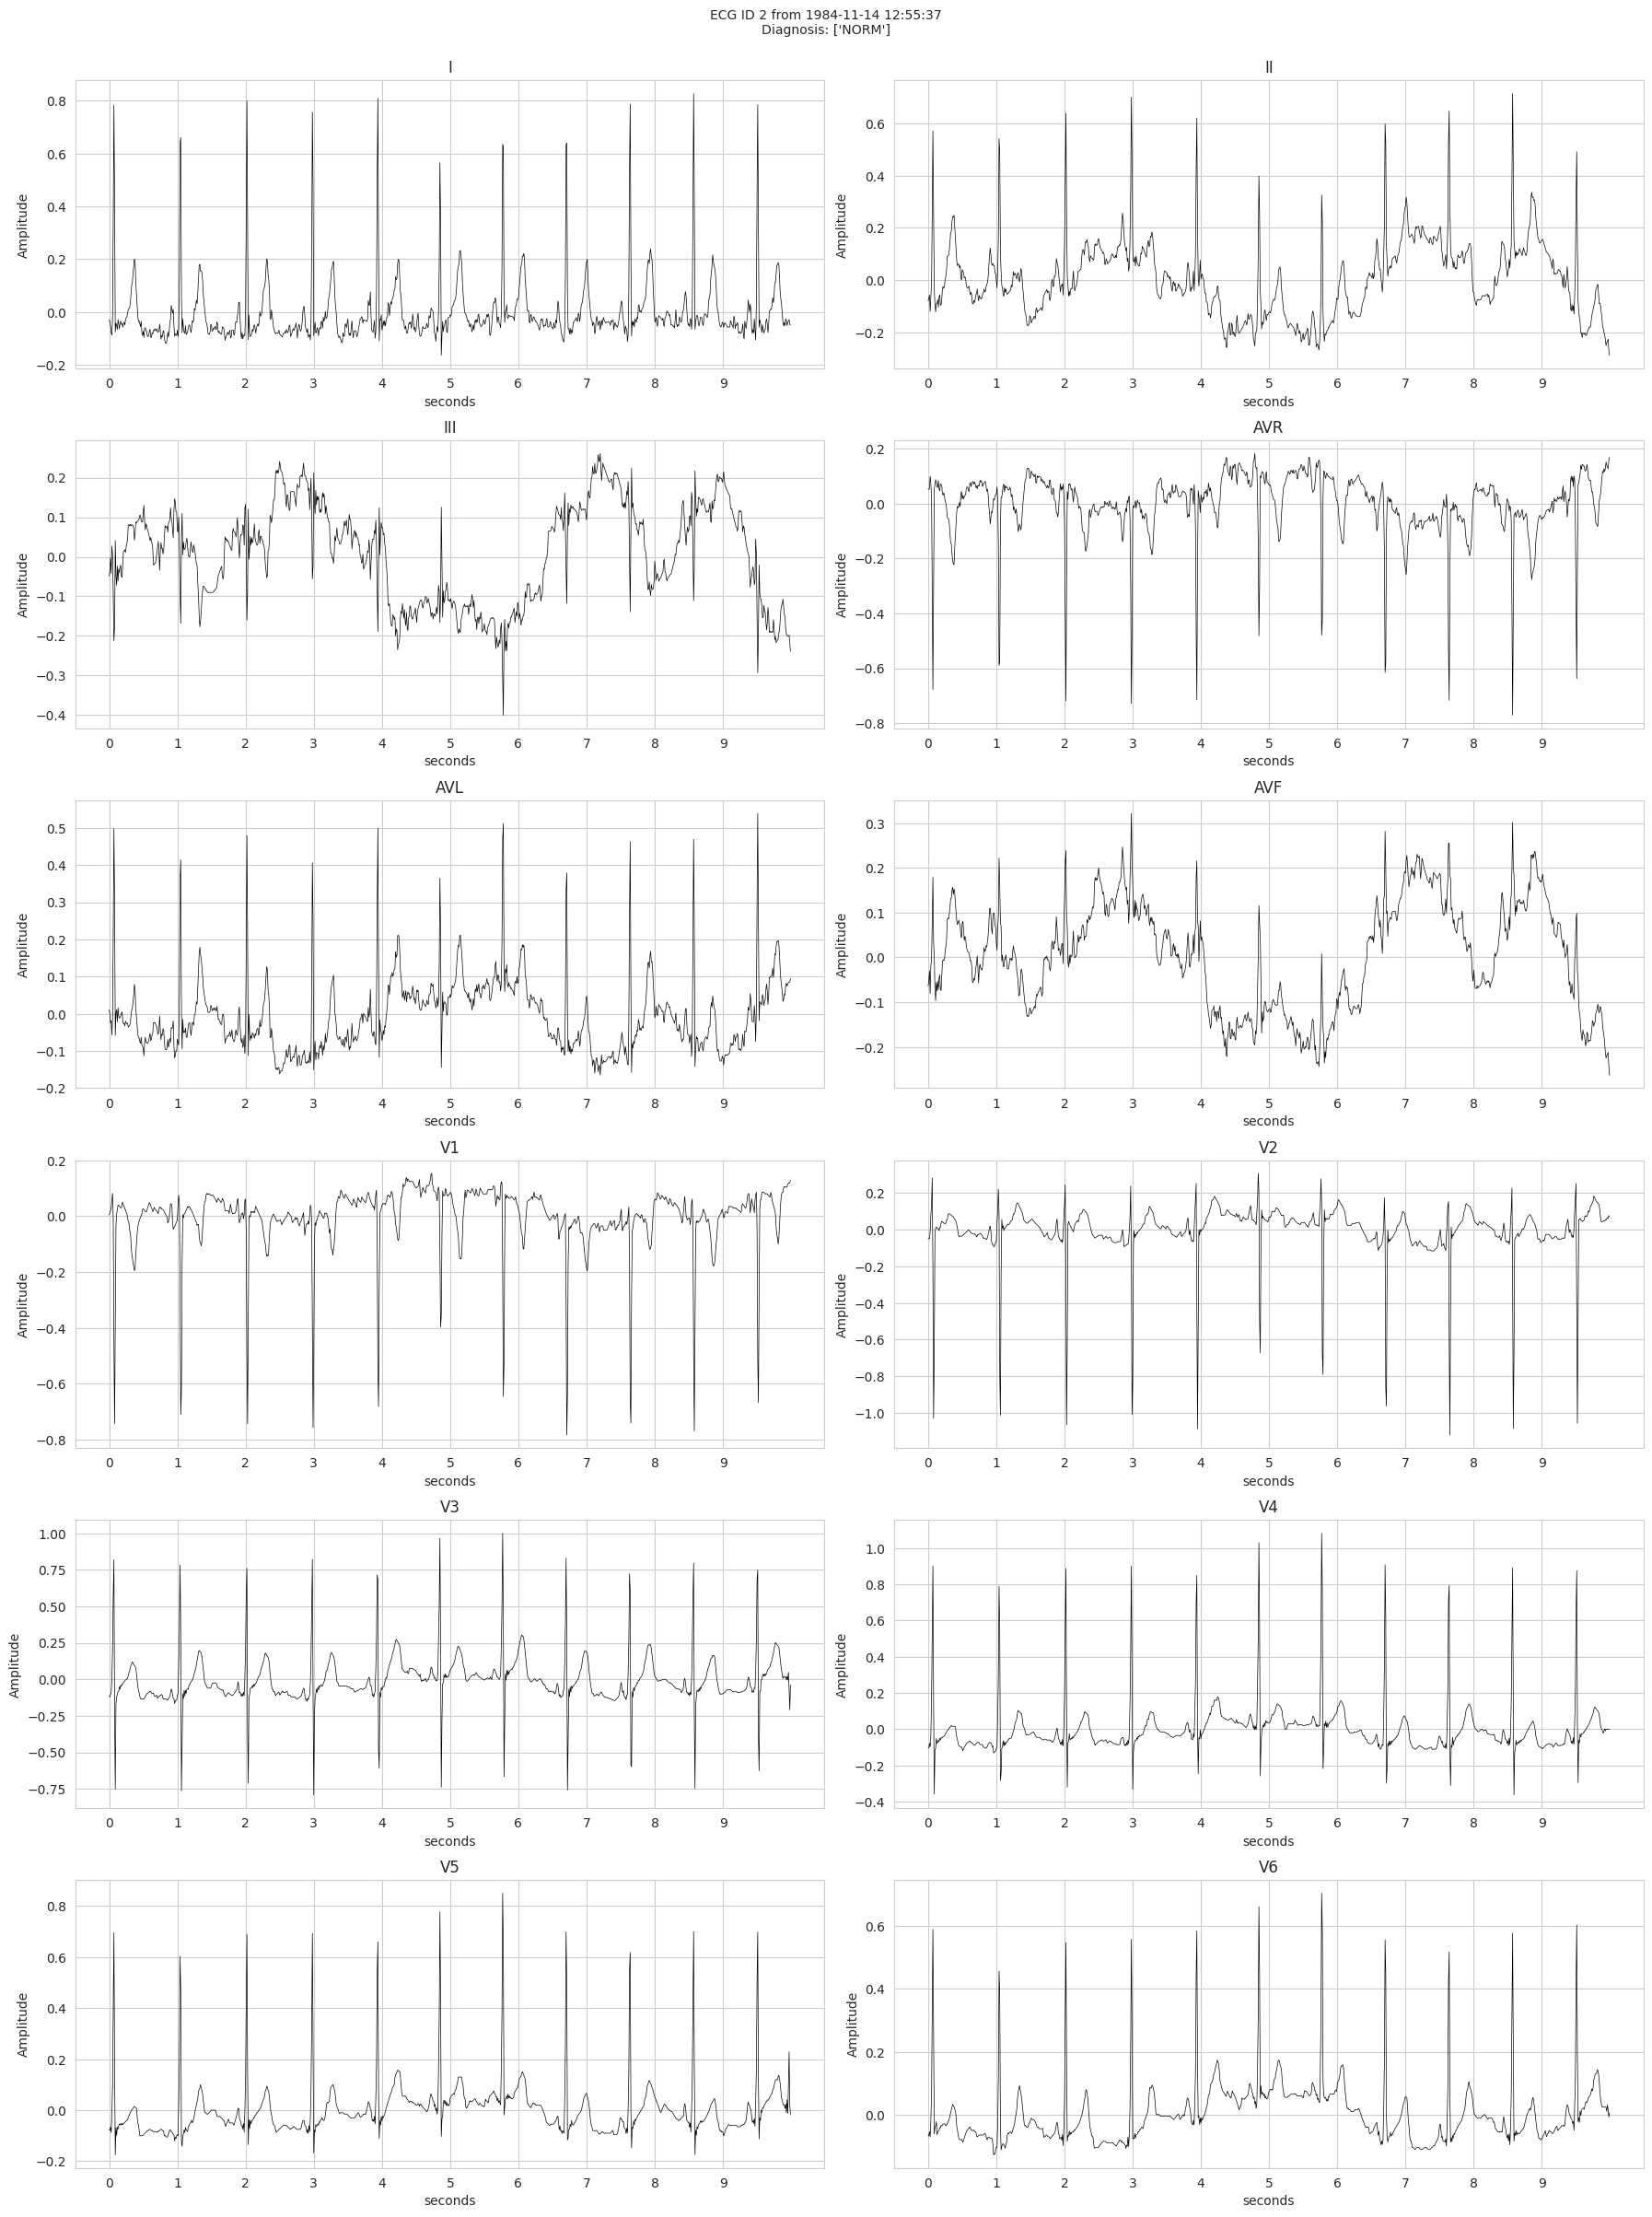

patient_id                                                  13243.0
age                                                            19.0
sex                                                            male
height                                                          NaN
weight                                                         70.0
nurse                                                           2.0
site                                                            0.0
device                                                    CS-12   E
recording_date                                  1984-11-14 12:55:37
report                          sinusbradykardie sonst normales ekg
scp_codes                              {'NORM': 80.0, 'SBRAD': 0.0}
heart_axis                                                      NaN
infarction_stadium1                                             NaN
infarction_stadium2                                             NaN
validated_by                                    

In [27]:
# Access a specific patient's data
patient_id = 13243
ecg_ids = dataloader.get_patient_id_ecg_ids(patient_id=patient_id,
                                          annotations=data['train']['annotations'])

print(f"Patient {patient_id} has {len(ecg_ids)} ECGs.")
ecg_id, ecg_date = ecg_ids[-1]  # most recent

signals = dataloader.get_signal_from_ecg_id(ecg_id=ecg_id,
                                          raw_data=data['train']['data'],
                                          channel=-1)

annots = dataloader.get_annotations_from_ecg_id(ecg_id=ecg_id,
                                              annotations=data['train']['annotations'])

# Visualize the ECG signal for all channels and annotations
data_display = data_plots.plot_ecg_channels(raw_data=data['train']['data'][ecg_id],
                                       title=f"ECG ID {ecg_id} from {ecg_date}\nDiagnosis: {data['train']['annotations']['diagnostic_superclass'][ecg_id]}")

# Display annotations
annots

#### Signal preprocessing steps

By preprocessing the signals, one can make them smoother, remove outliers, etc.

##### Filtering

A common pre-process when working with signals is smoothing/filtering. That allows to remove some outliers and noise from the signal for a better analysis.

Some of the most used signal filtering techniques are:
- Savitzky-Golay filter
- Gaussian filter
- Median filter
- Low-pass filter
- High-pass filter
- Butterworth filter (band-pass filter)
- Convolution filter

The biggest challenge of filtering is the manual tunning. Finding the right parameters is a empirical work.

Below, some filters applied to the same signal.

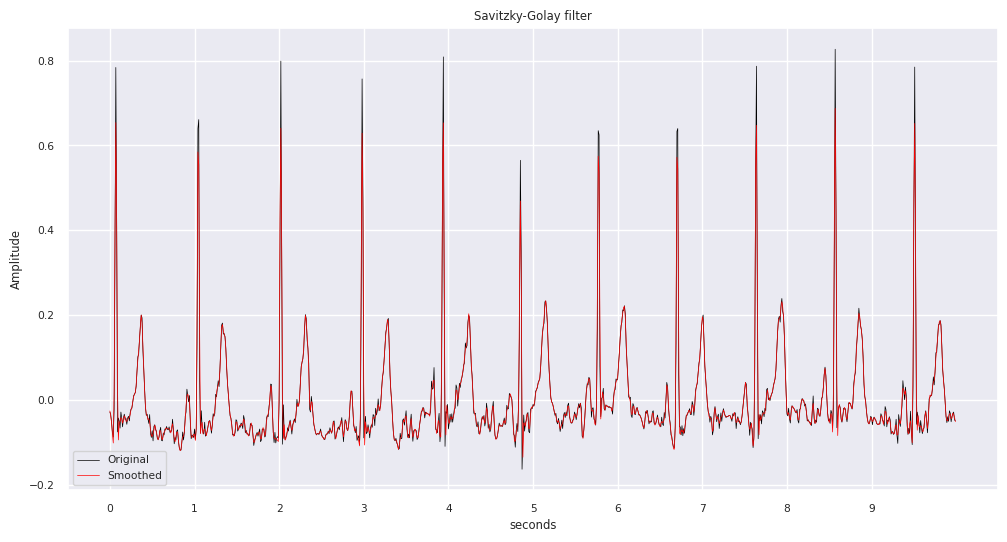

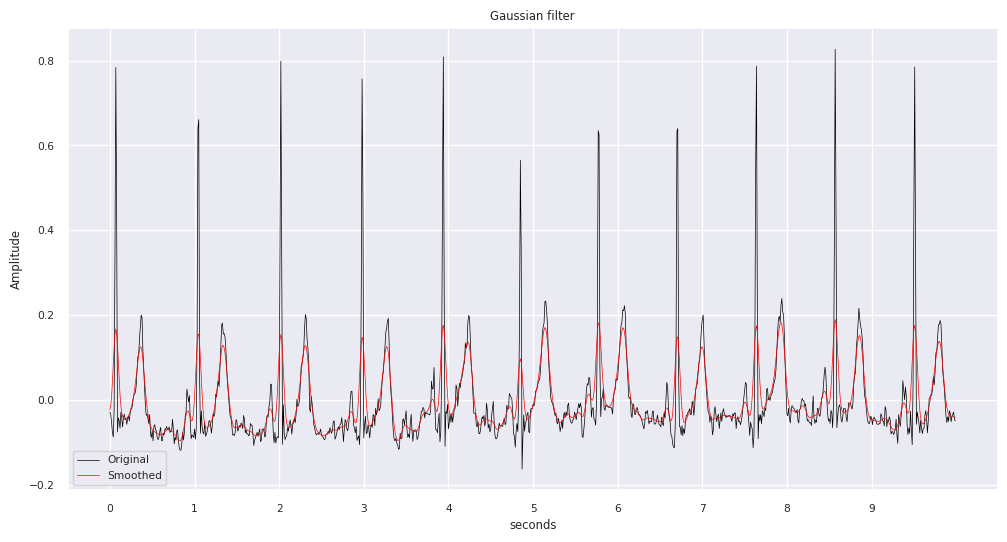

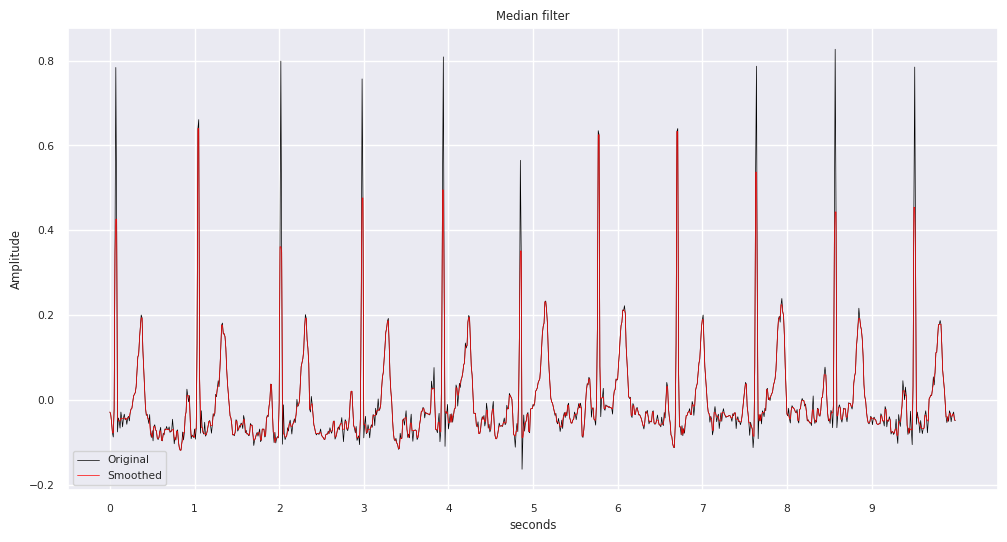

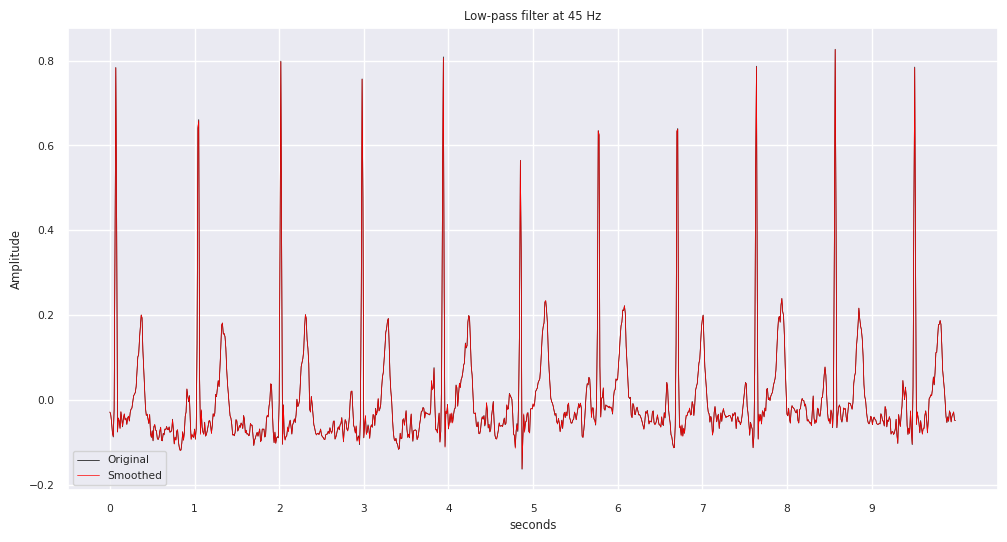

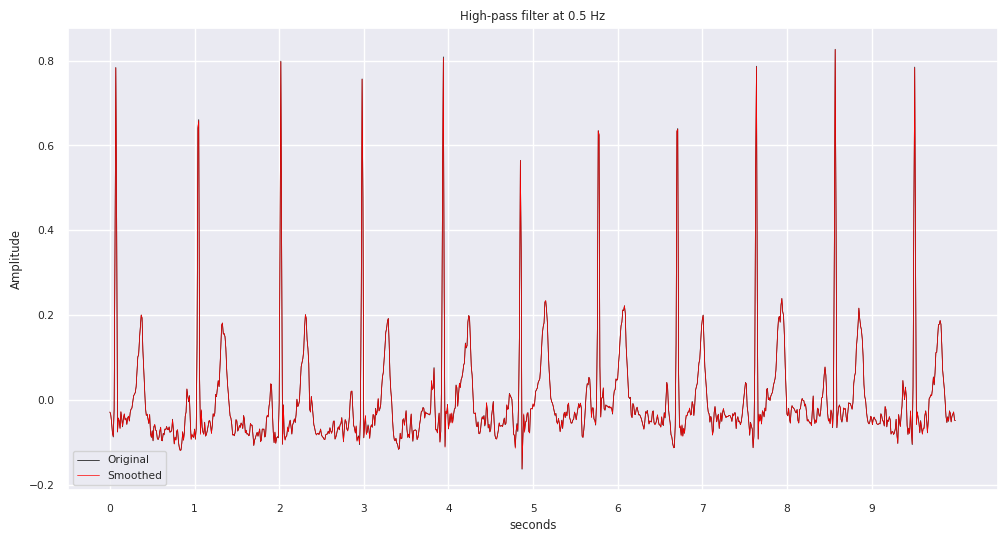

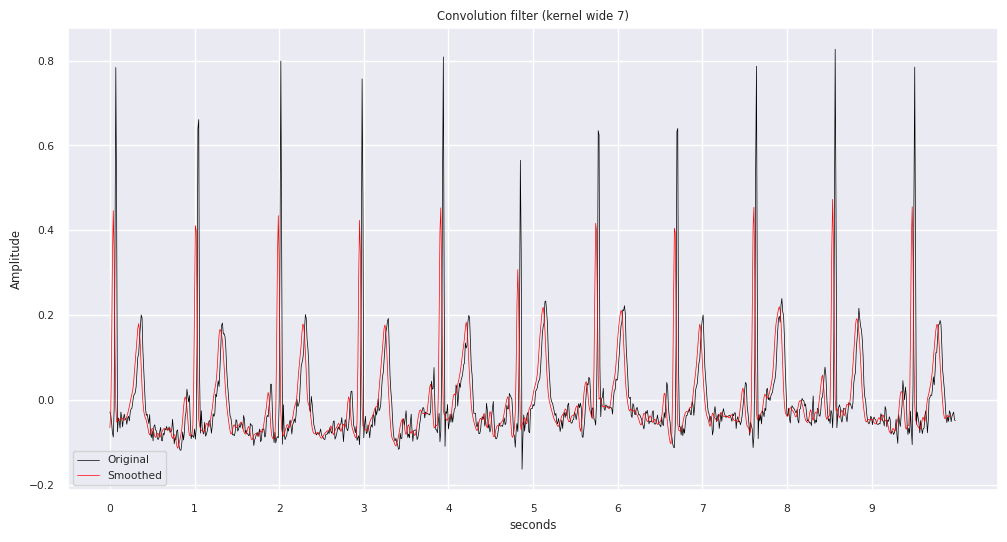

In [28]:
channel = 0
original_signal = signals[:, channel]

# Savitzky-Golay filter
savgol_ecg = signal_processor.smooth_signal_savgol(ecg_signal=original_signal,
                                        window_length=5,
                                        polyorder = 2)
data_plots.plot_filtered_signal(ecg_signal=original_signal,
                           smoothed_ecg=savgol_ecg,
                           title="Savitzky-Golay filter")
# Gaussian filter
gaussian_ecg = signal_processor.smooth_signal_gaussian(ecg_signal=original_signal, sigma=3)
data_plots.plot_filtered_signal(ecg_signal=original_signal,
                           smoothed_ecg=gaussian_ecg,
                           title="Gaussian filter")
# Median filter
median_ecg = signal_processor.smooth_signal_median(ecg_signal=original_signal, kernel_size=3)
data_plots.plot_filtered_signal(ecg_signal=original_signal,
                           smoothed_ecg=median_ecg,
                           title="Median filter")

# Low-pass filter
lowcut = 45
lowpass_ecg = signal_processor.smooth_signal_lowpass(ecg_signal=original_signal,
                                          sample_rate=100,
                                          order_filter=5,
                                          cut=lowcut)
data_plots.plot_filtered_signal(ecg_signal=original_signal,
                           smoothed_ecg=lowpass_ecg,
                           title=f"Low-pass filter at {lowcut} Hz")

# High-pass filter
highcut = 0.5
highpass_ecg = signal_processor.smooth_signal_highpass(ecg_signal=original_signal,
                                          sample_rate=100,
                                          order_filter=5,
                                          cut=highcut)
data_plots.plot_filtered_signal(ecg_signal=original_signal,
                           smoothed_ecg=lowpass_ecg,
                           title=f"High-pass filter at {highcut} Hz")

# Convolution filter
kernel = 7
conv_ecg = signal_processor.smooth_signal_convolution(ecg_signal=original_signal,
                                           kernel=kernel)
data_plots.plot_filtered_signal(ecg_signal=original_signal,
                           smoothed_ecg=conv_ecg,
                           title=f"Convolution filter (kernel wide {kernel})")

An example of manual tuining can be: see the influence of difference frequency cuts on a low-filter.

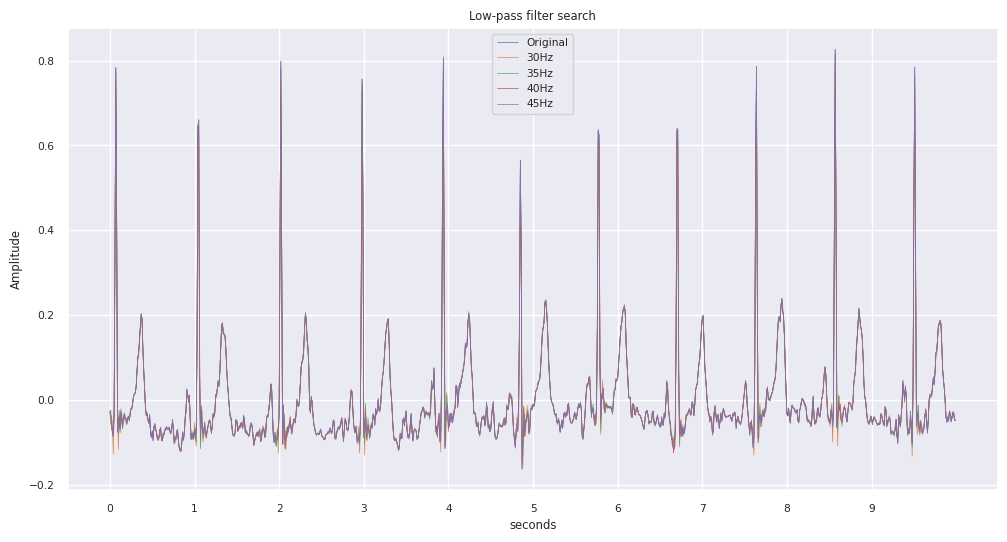

In [29]:
lowpass_ecgs = []
cutoffs = []
for lowcut in range(30, 50, 5):
    lowpass_ecg = signal_processor.smooth_signal_lowpass(ecg_signal=original_signal,
                                            sample_rate=100,
                                            order_filter=5,
                                            cut=lowcut)
    lowpass_ecgs.append(lowpass_ecg)
    cutoffs.append(f"{lowcut}Hz")

data_plots.plot_filtered_signals(ecg_signal=original_signal,
                           smoothed_ecgs=lowpass_ecgs,
                           labels=cutoffs,
                           title="Low-pass filter search")

Filtering is commonly used to eliminate baseline wander, a common artifact that distorts ECG signals. This artifact can arise from various noise sources, such as respiration, body movements, and poor electrode contact, and typically affects frequencies below 0.5 Hz.

However, most baseline wander removal methods can alter the ECG signal, potentially compromising its clinical significance, making the process challenging.

A simple baseline wander estimator was implemented using a sequence of median filters with varying kernel sizes. The kernel size is determined based on the sampling rate and the desired window duration in seconds.

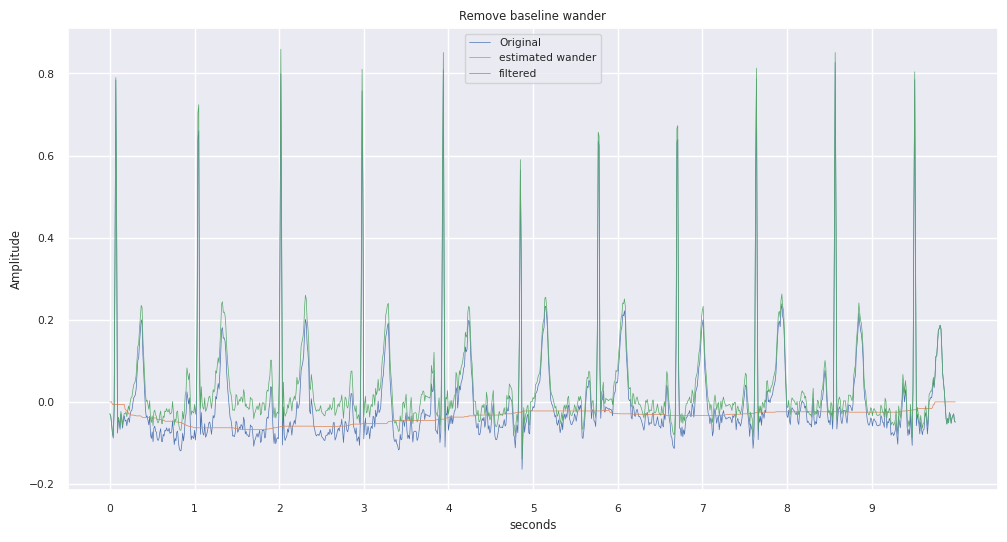

In [30]:
wander = signal_processor.estimate_baseline_wander(ecg_signal=original_signal,durations=[0.5, 2], sample_rate=100)
rem_wander_ecg = signal_processor.remove_baseline_wander(ecg_signal=original_signal,durations=[0.5, 2], sample_rate=100)

data_plots.plot_filtered_signals(ecg_signal=original_signal,
                           smoothed_ecgs=[wander, rem_wander_ecg],
                           labels=['estimated wander', 'filtered'],
                           title="Remove baseline wander")

Once we have the ECG signal, there are several basic analyses that can be performed. One of the most important aspects of an ECG is the [QRS complex](https://en.wikipedia.org/wiki/QRS_complex)., which provides key information about the heart's electrical activity.

In simple terms:

- R peaks are the highest points in the ECG waveform.
- Q peaks are the lowest points before the R peak.
- S peaks are the lowest points after the R peak.
  
The R peaks can be used to estimate the heart rate.

Some commonly used algorithms for detecting the QRS complex include:

- Pan and Tompkins
- Hamilton
- Christov
- Stationary Wavelet Transform
- Two Moving Average
  
You can find an implementation of these detectors [here](https://github.com/berndporr/py-ecg-detectors). However, after testing it, in many cases, the R peak detection was inaccurate. So, an alternative implementation of  [Pan and Tompkins QRS complex detector](https://en.wikipedia.org/wiki/Pan%E2%80%93Tompkins_algorithm) has been used and imported in this project.


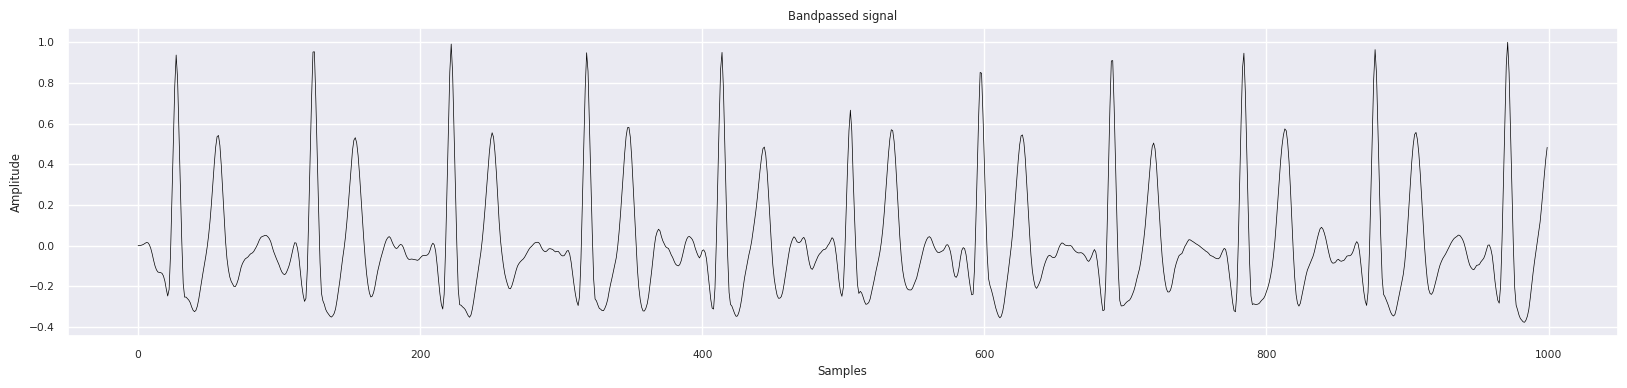

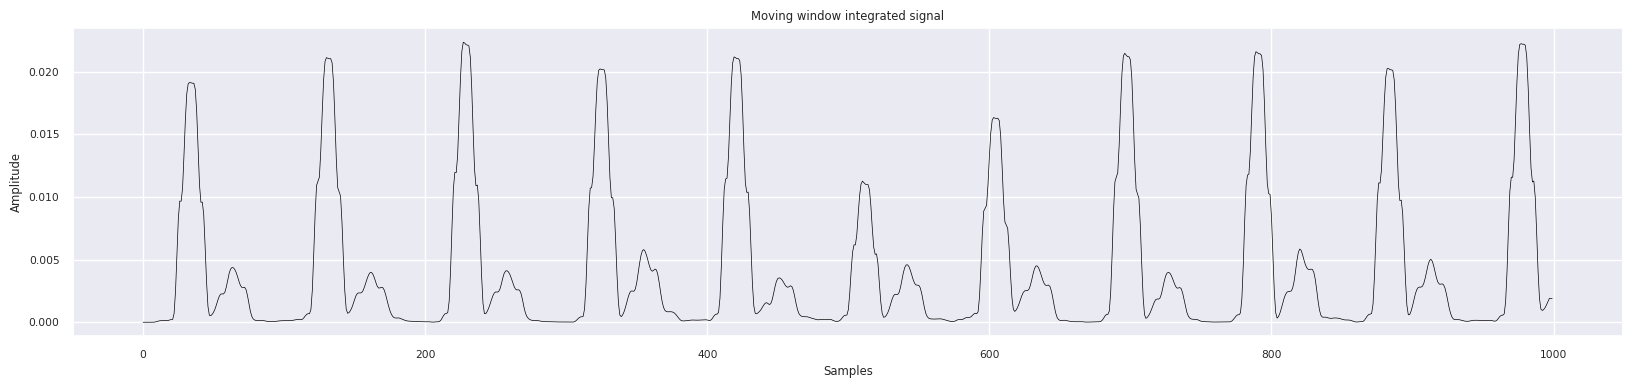

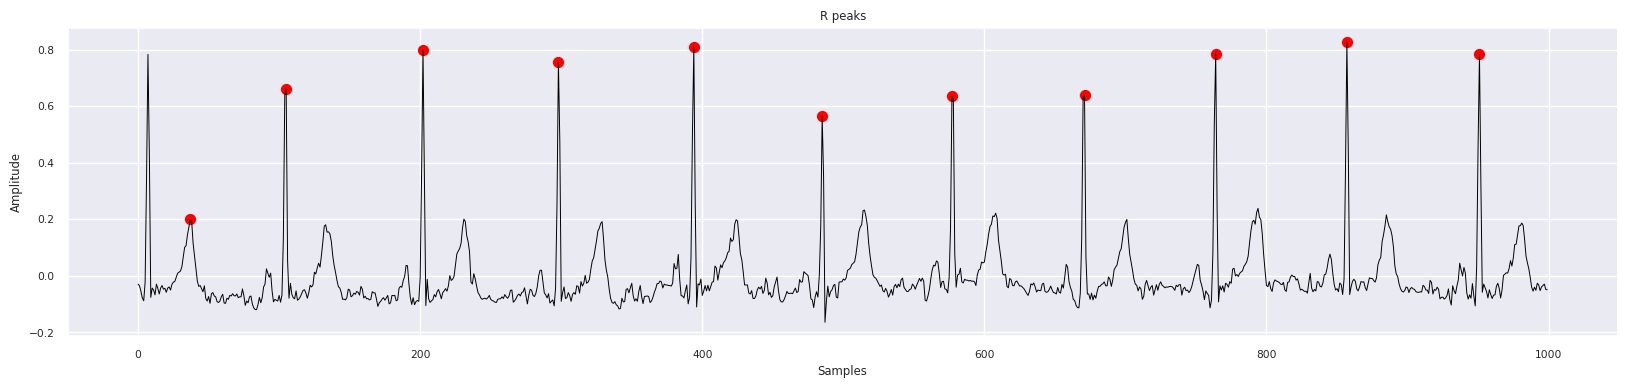

Heart rate: 63.83 +- 0.17 bpm


In [31]:
peak_detector = signal_processor.PanTompkinsQRS(signal=original_signal, sample_rate=100, window_size=0.15)

data_plots.plot_signal(signal=peak_detector.band_pass_sgn,
                  xlabel="Samples",
                  ylabel="Amplitude",
                  title="Bandpassed signal")

data_plots.plot_signal(signal=peak_detector.mov_win_sgn,
                  xlabel="Samples",
                  ylabel="Amplitude",
                  title="Moving window integrated signal")

peak_detector.find_r_peaks()

data_plots.plot_signal_and_rpeaks(signal=original_signal,
                             rpeaks_loc=peak_detector.tuned_peaks,
                             xlabel="Samples",
                             ylabel="Amplitude",
                             title="R peaks")

heart_bpm, heart_var = peak_detector.estimate_heartrate()
print(f"Heart rate: {heart_bpm:.2f} +- {heart_var:.2f} bpm")

#### EDA of train/validation/test splits

Look for possible biases among the splits before training the model.

Use the splits as suggested:


<div style="border: 1px solid #ddd; border-radius: 5px; padding: 10px; background-color: #f9f9f9;">

Cross-validation Folds: recommended 10-fold train-test splits (strat_fold) obtained via stratified sampling while respecting patient assignments, i.e. all records of a particular patient were assigned to the same fold. Records in fold 9 and 10 underwent at least one human evaluation and are therefore of a particularly high label quality. We therefore propose to use folds 1-8 as training set, fold 9 as validation set and fold 10 as test set.

</div>


Number of classes: 5


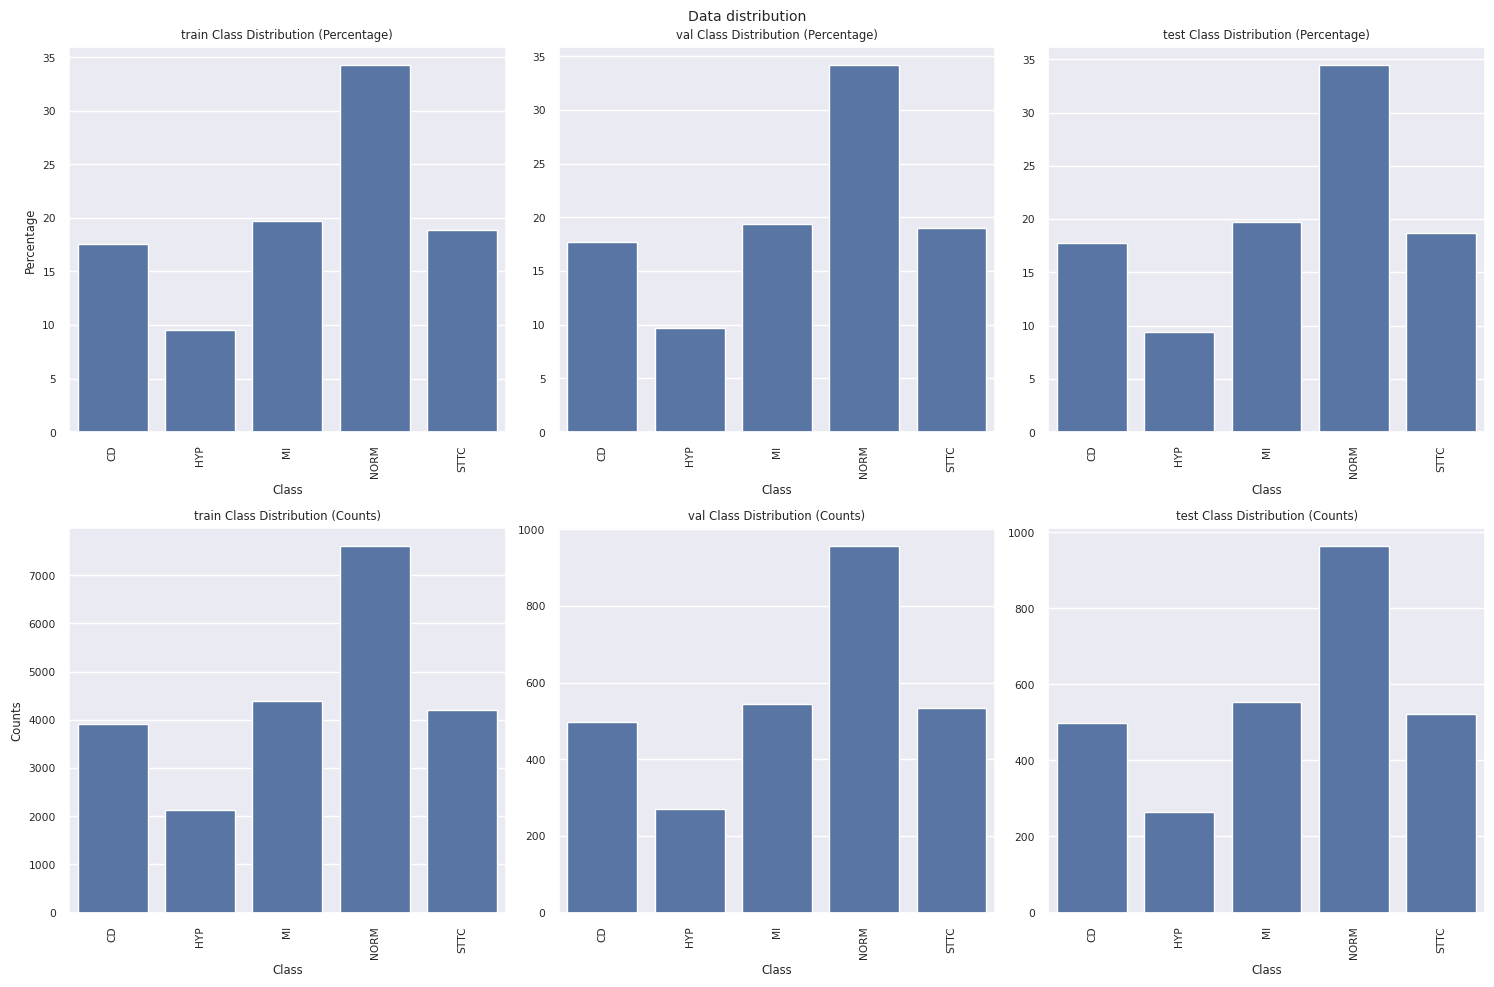

Number of classes: 22


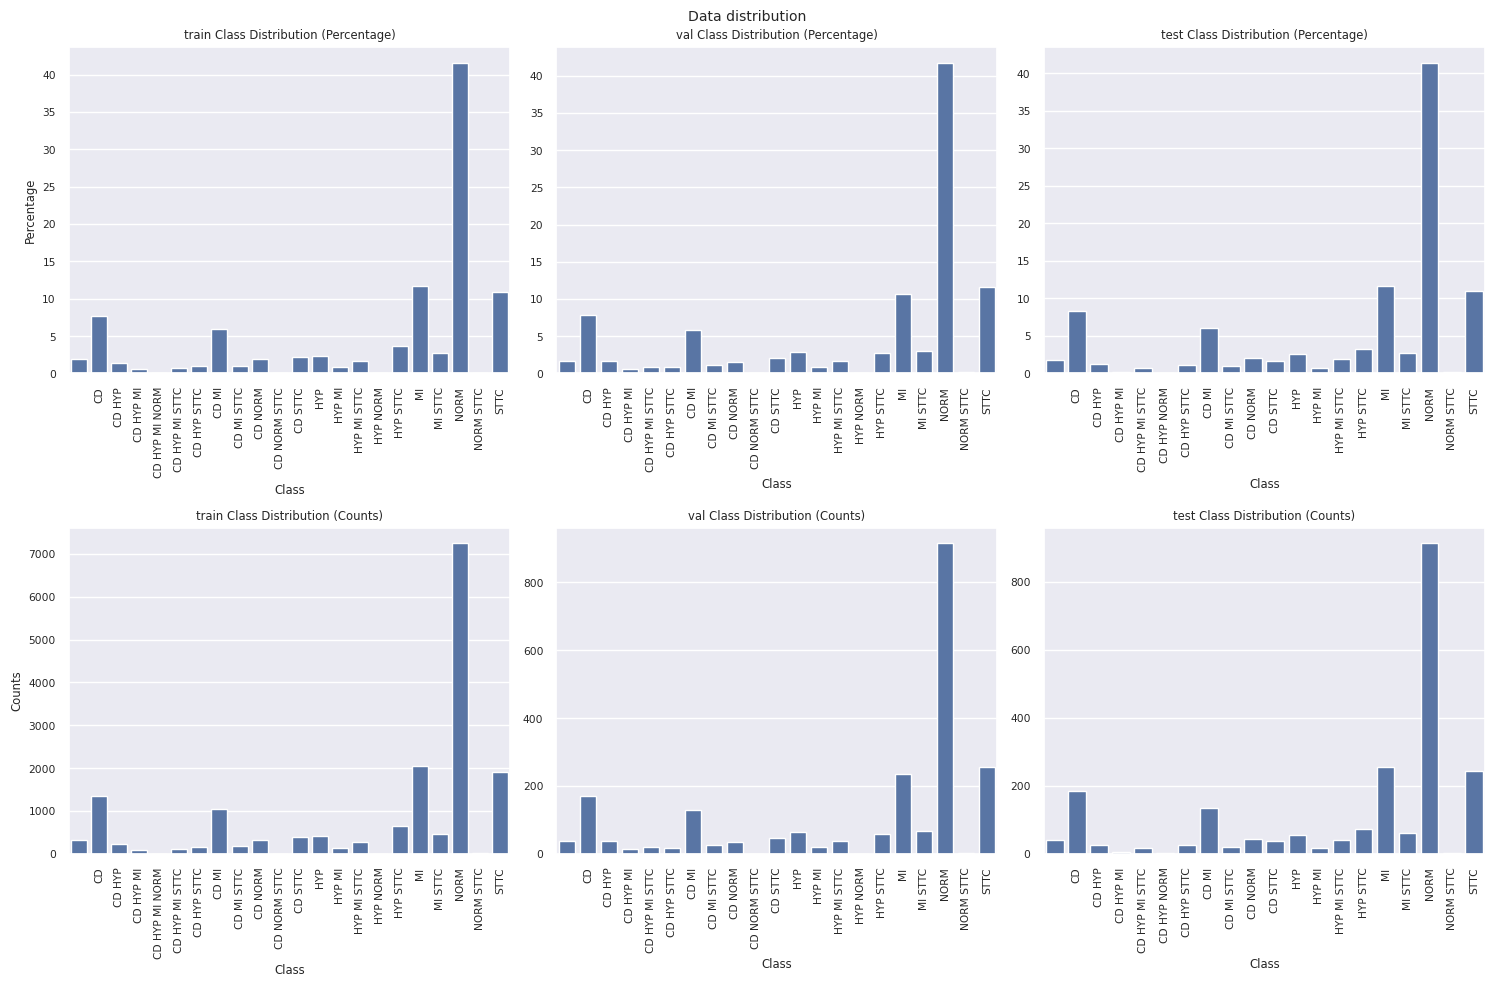

In [32]:
from utils.utilities import calculate_distribution

datasets = ["train", "val", "test"]
class_counts = {}
class_percentages = {}

for dataset in datasets:
    class_counts[dataset], class_percentages[dataset] = calculate_distribution(data[dataset]["labels"],
                                                                                       use_combo=False)

num_classes = len(class_counts["train"])
print(f"Number of classes: {num_classes}")

data_plots.plot_data_distribution(class_counts, class_percentages)

datasets = ["train", "val", "test"]
class_counts = {}
class_percentages = {}

for dataset in datasets:
    class_counts[dataset], class_percentages[dataset] = calculate_distribution(data[dataset]["labels"],
                                                                                       use_combo=True)

num_classes = len(class_counts["train"])
print(f"Number of classes: {num_classes}")

data_plots.plot_data_distribution(class_counts, class_percentages)

In [33]:
for ds_type in datasets:
    single_label = 0
    norm_label = 0
    multi_label = 0
    for key, perc in class_percentages[ds_type].items():
        if " " in key:
            multi_label += perc
        else:
            single_label += perc
            if "norm" == key.lower():
                norm_label += perc
    print(f"Dataset type: {ds_type}")
    print(f"\tPercentage of single labels: {single_label:.2f}%")
    print(f"\t\tNORM contribution: {norm_label:.2f}%")
    print(f"\t\tNon NORM contribution: {single_label - norm_label:.2f}%")
    print(f"\tPercentage of multi labels: {multi_label:.2f}%")

Dataset type: train
	Percentage of single labels: 76.30%
		NORM contribution: 41.59%
		Non NORM contribution: 34.71%
	Percentage of multi labels: 23.70%
Dataset type: val
	Percentage of single labels: 76.56%
		NORM contribution: 41.77%
		Non NORM contribution: 34.79%
	Percentage of multi labels: 23.44%
Dataset type: test
	Percentage of single labels: 76.80%
		NORM contribution: 41.44%
		Non NORM contribution: 35.36%
	Percentage of multi labels: 23.20%


We observe that there are 5 unique labels and 22 out of the 31 possible label combinations.

A few additional points to note:

- Some data points lack a class label.
- The data is balanced across different splits.
- Single labels dominate the dataset.
- The label "NORM" alone accounts for approximately 40% of the data in each split.
- The data does not exhibit a long-tail distribution (when ignoring label combinations).

Given that this is a health-related use case, factors like sex and age are often critical. Let's verify if this data is also well-distributed.

In [34]:
from collections import Counter
for ds_type in datasets:
    sex_count = Counter(data[ds_type]["annotations"].sex)
    total = sum(sex_count.values())
    print(f"Dataset type: {ds_type}")
    print(f"\tMale percentage: {sex_count['male']/total:.2%} ({sex_count['male']})")
    print(f"\tFemale percentage: {sex_count['female']/total:.2%} ({sex_count['female']})")

Dataset type: train
	Male percentage: 52.20% (9104)
	Female percentage: 47.80% (8337)
Dataset type: val
	Male percentage: 52.16% (10242)
	Female percentage: 47.84% (9392)
Dataset type: test
	Male percentage: 52.11% (11379)
	Female percentage: 47.89% (10458)


Although there is a slightly prevalence of `male`, the `sex` attribute is properly distributed between splits as in the original dataset.

Let's analyze the `age` distribution per `sex`.

Dataset type: train


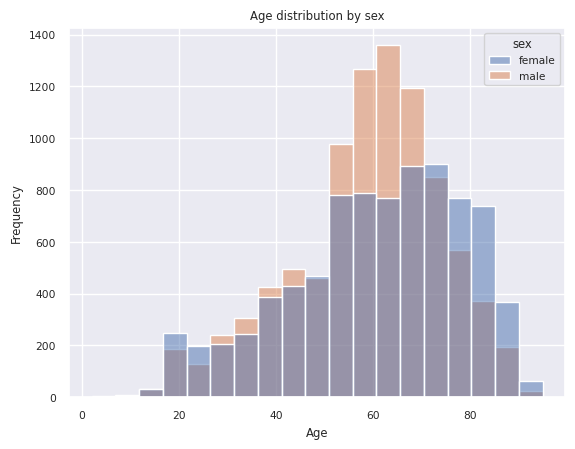

Dataset type: val


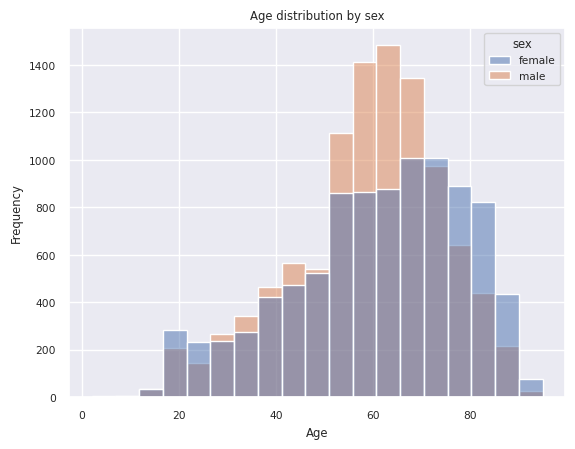

Dataset type: test


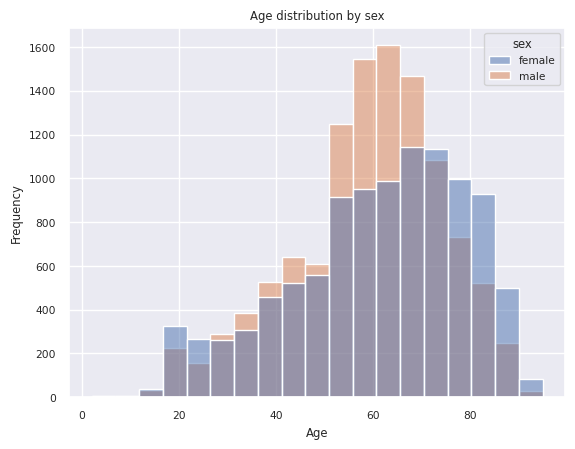

In [35]:
for ds_type in datasets:
    print(f"Dataset type: {ds_type}")
    data_plots.plot_distribution_age_sex(data[ds_type]["annotations"])

`age` and `sex` distribution is very similar among splits. We have more `female` data in the extremes and more `male` data in the centre

This last points alert us to check for bias in the results later on.

Finally, lets check the `diagnostic` distribution per `sex`.

Dataset type: train


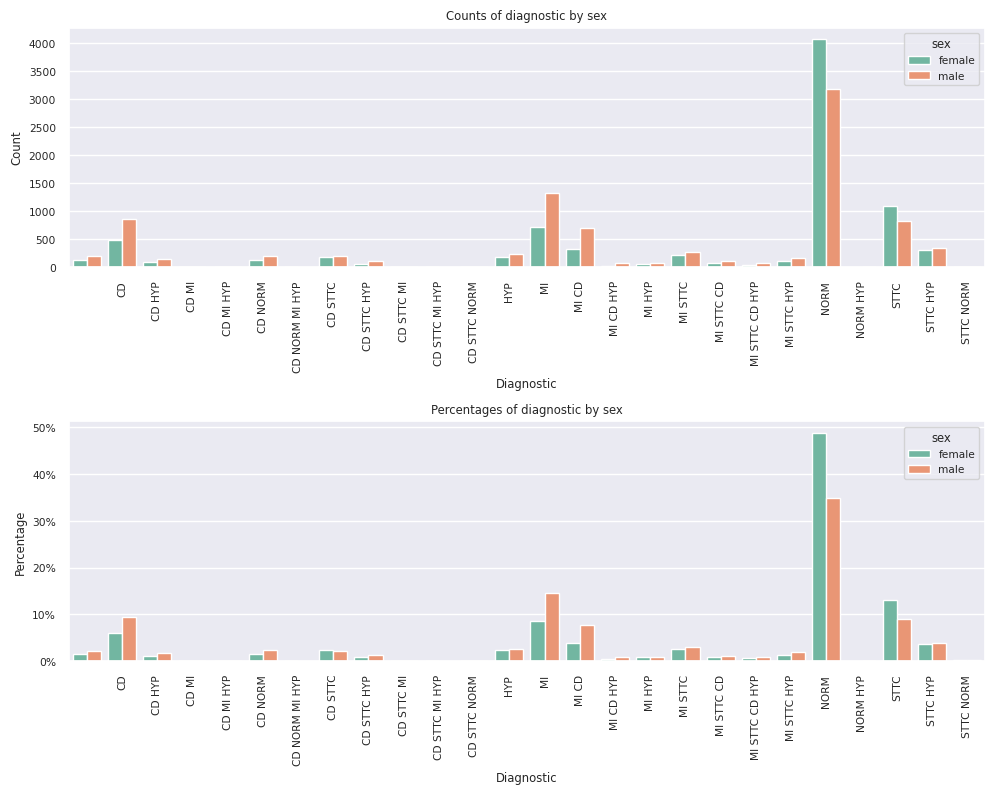

Dataset type: val


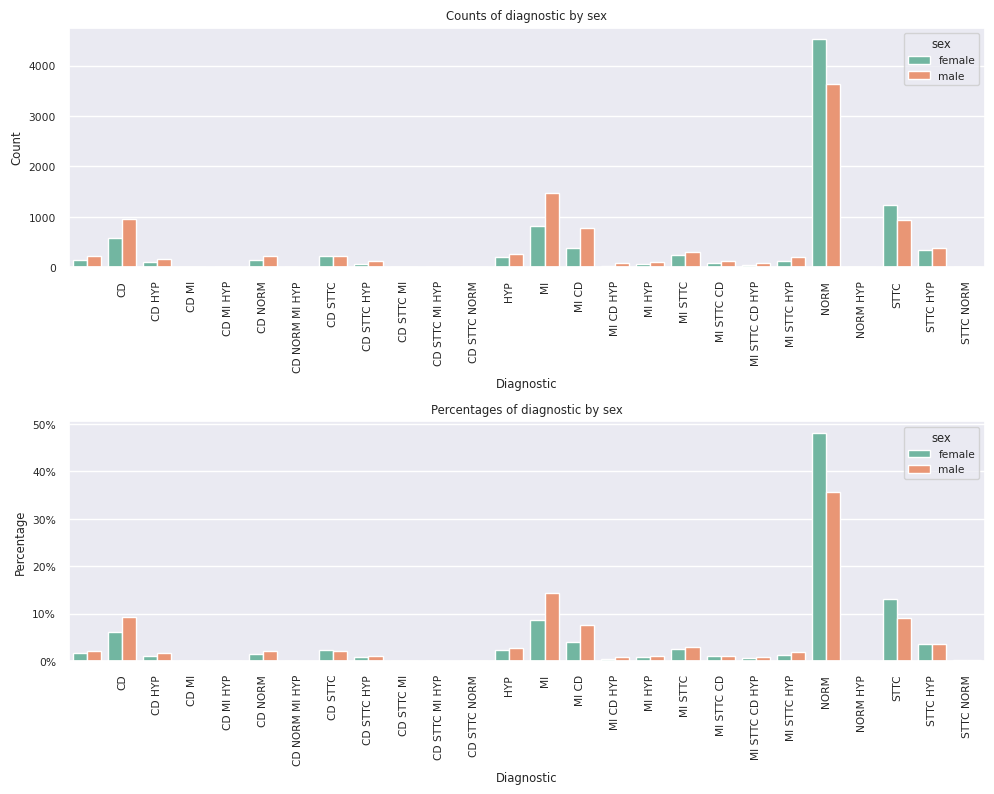

Dataset type: test


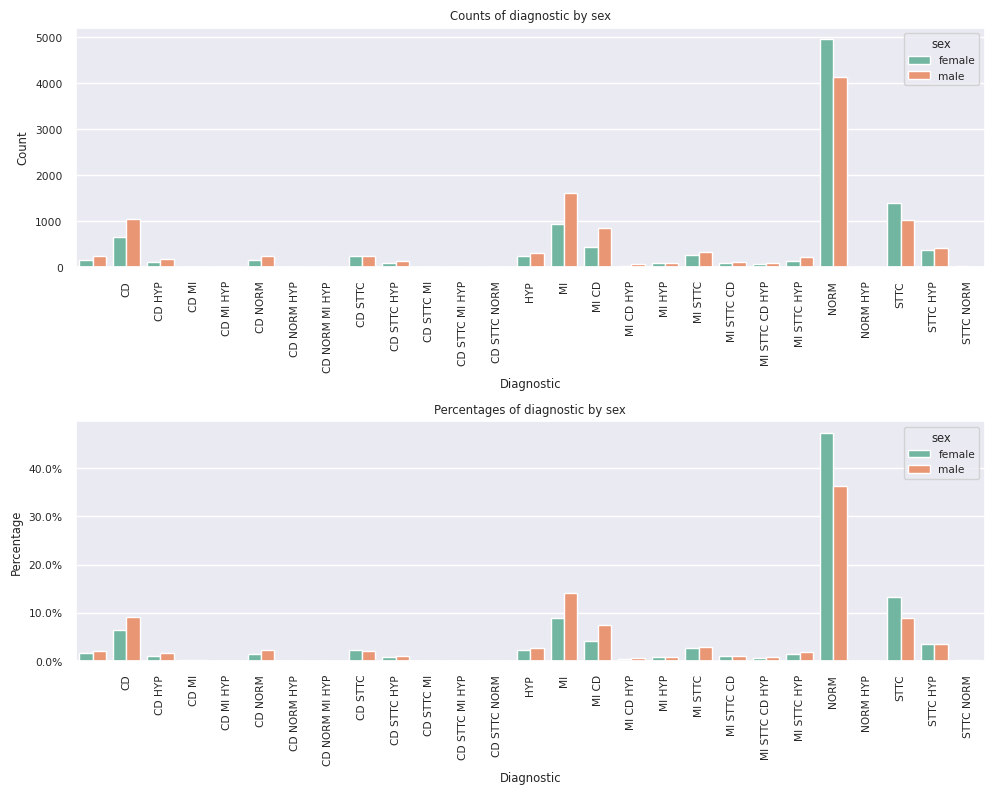

In [36]:
for ds_type in datasets:
    print(f"Dataset type: {ds_type}")
    data_plots.plot_distribution_diagnostic_sex(data[ds_type]["annotations"])

The `diagnostic` distribution per `sex` in the different splits is similar.
`female` has more `NORM` diagnostics. That means that the we have less females in the data and they are mostly healthy. One can expect to be harder to detect problems with a model on females. Something to confirm later.

## Data Augmentation: balancing datasets according to class labels

In this multi-label problem, we have observed that the data is well distributed across splits with respect to `diagnostic`, `sex` and `age`.

However, the label `NORM`  is notably dominant, representing approximately 35% of the data in each split, while the next most common label accounts for about 20%.

The challenge now is to explore if data augmentation can improve model performance. Ideally, a more balanced label distribution within the training split should yield better results. However, this theoretical advantage may not always hold true, and the effectiveness can only be determined through training and testing the models.


**Original data splits distributions**

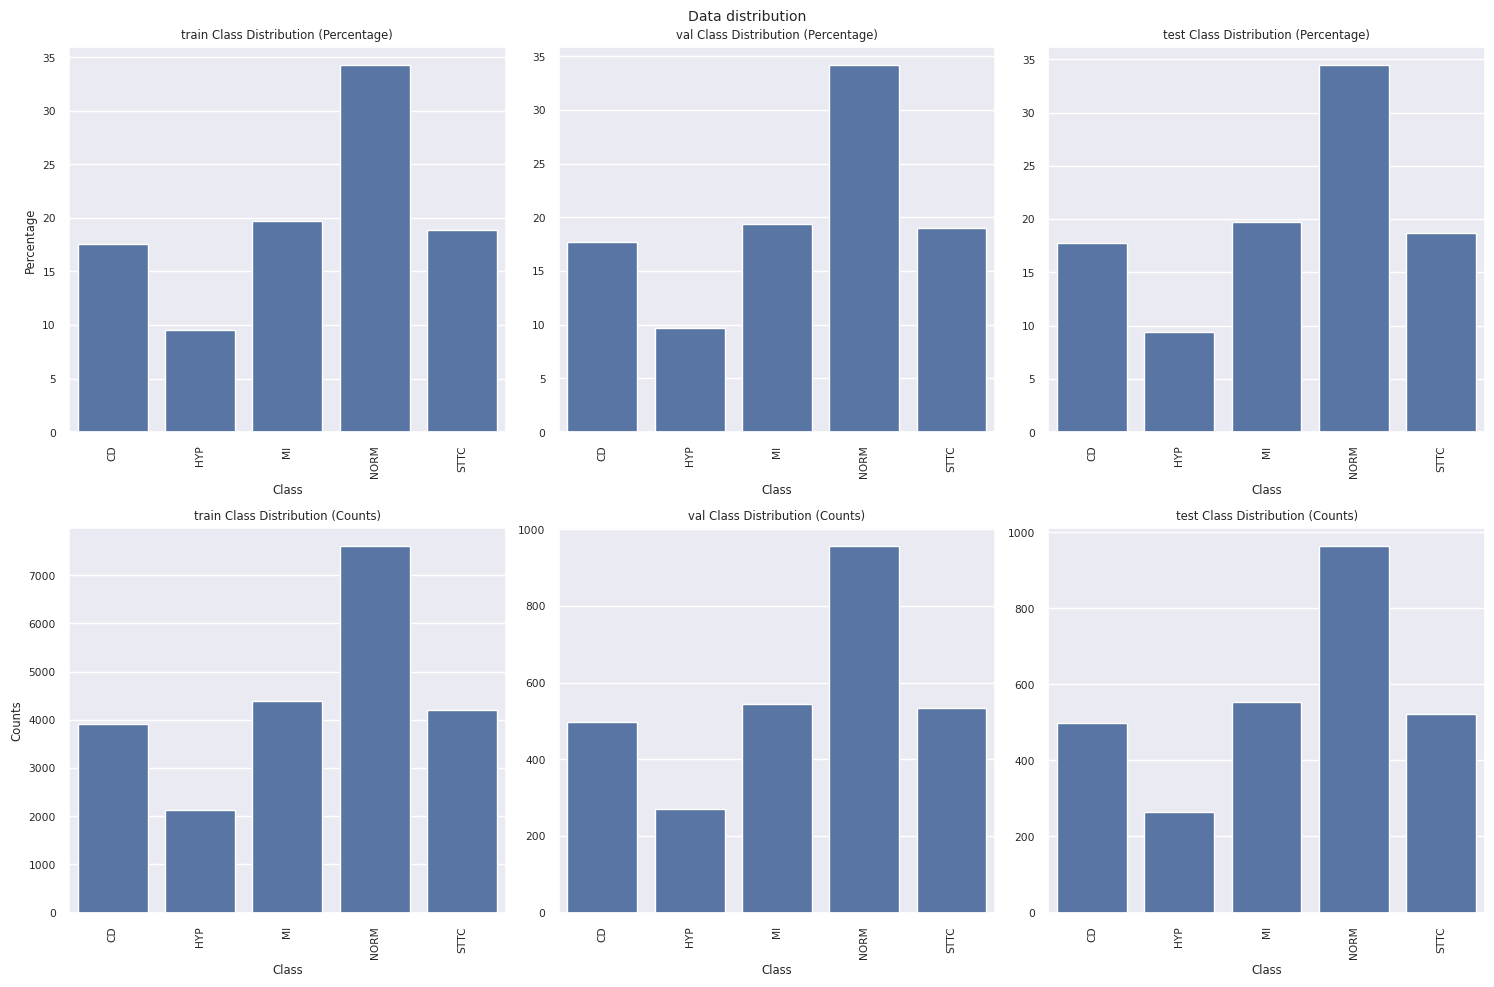

Number of classes: 5
Classes: Counter({'NORM': 7607, 'MI': 4389, 'STTC': 4193, 'CD': 3912, 'HYP': 2121})


In [37]:
# Recap of the original distribution
datasets = ["train", "val", "test"]
class_counts = {}
class_percentages = {}

for dataset in datasets:
    class_counts[dataset], class_percentages[dataset] = calculate_distribution(data[dataset]["labels"],
                                                                                       use_combo=False)
data_plots.plot_data_distribution(class_counts, class_percentages)

num_classes = len(class_counts["train"])
print(f"Number of classes: {num_classes}")
print(f"Classes: {class_counts['train']}")

**Balancing the data splits distributions**

The augmentation strategy will focus on cases with a single label. After resampling this data, multi-labeled cases will be added to the dataset.

We will evaluate the following six data distributions:

- Use the data as it is.
- Use only the oversampled/undersampled data with a single label.
- Oversample/undersample the data with a single label and add the multi-labeled cases.
- Use only the multi-labeled cases.

-- Single label only


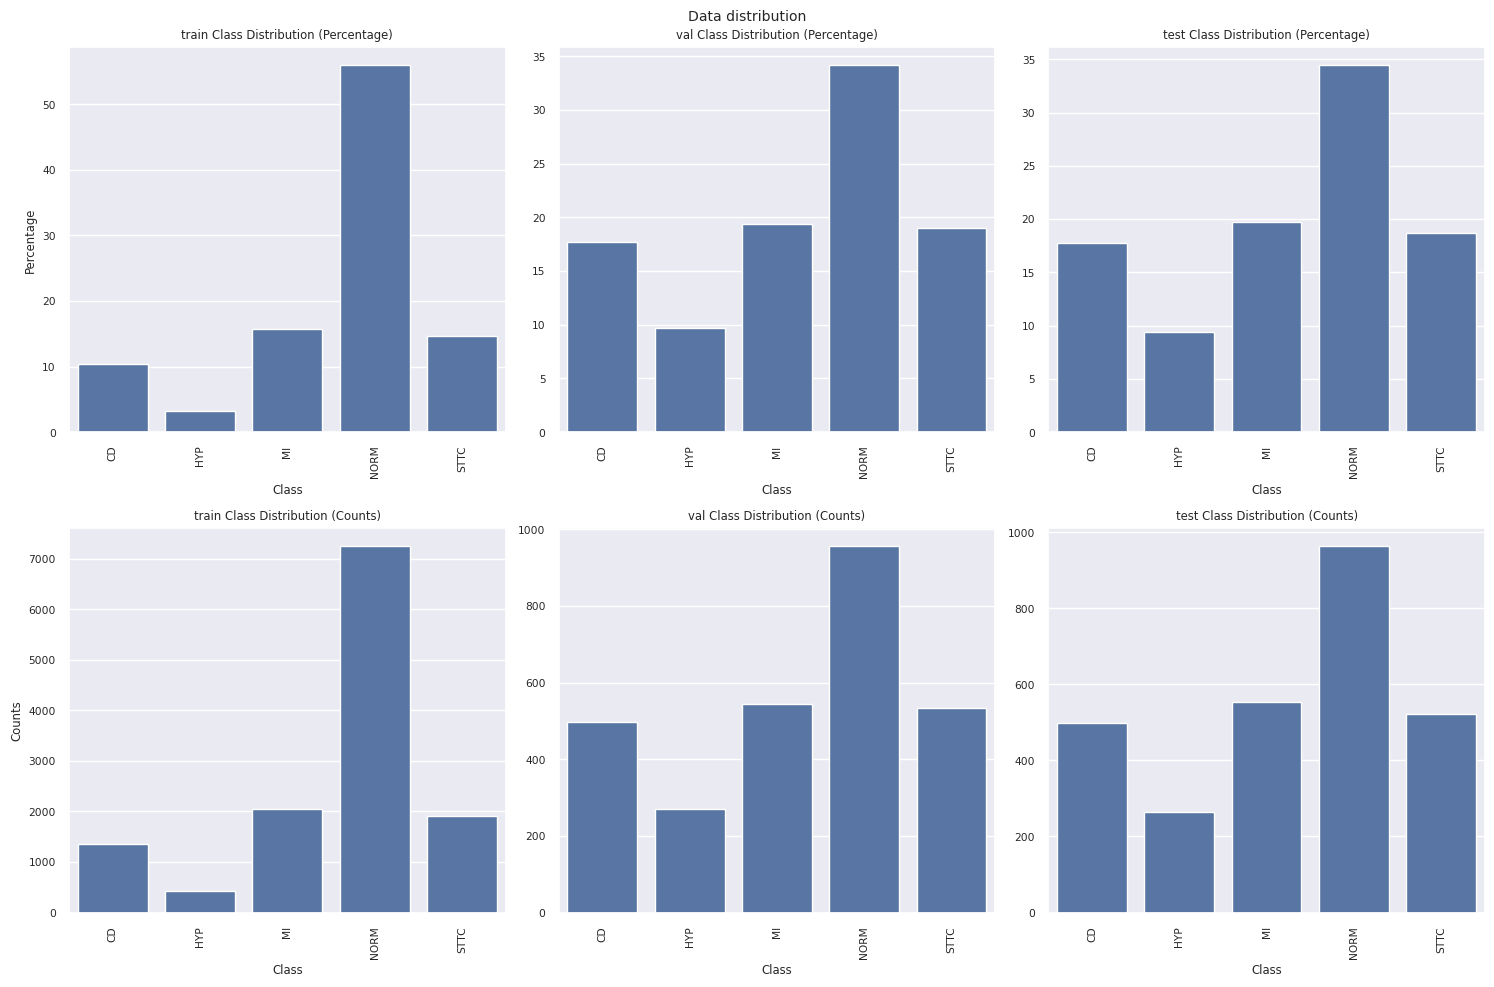

-- Multiple label only


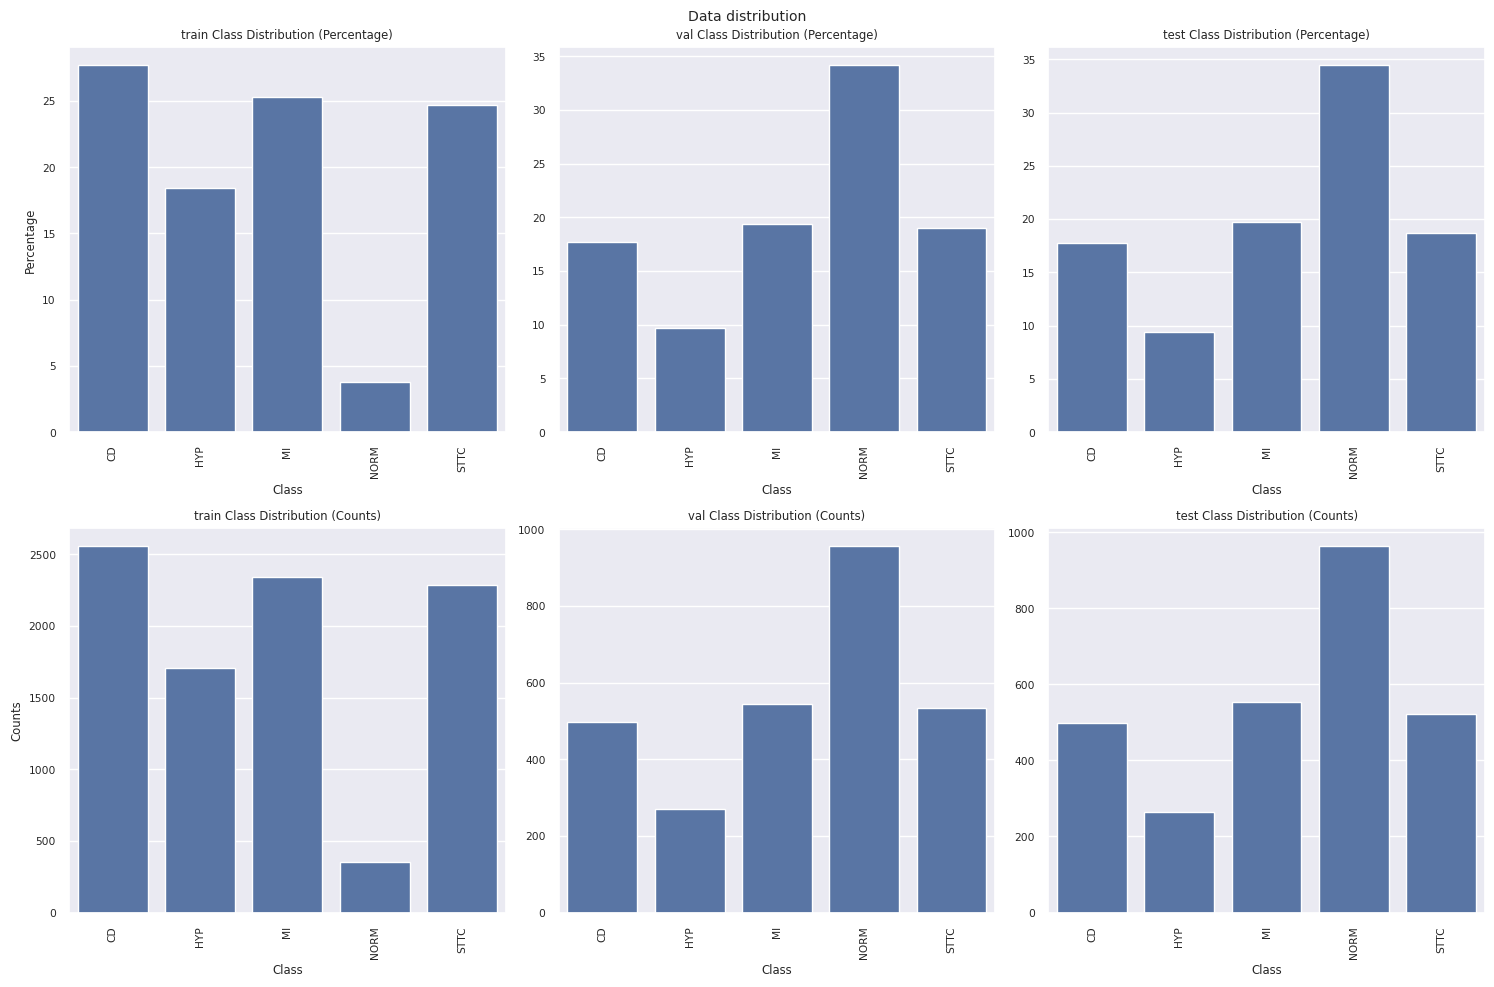

-- Single label under sampled


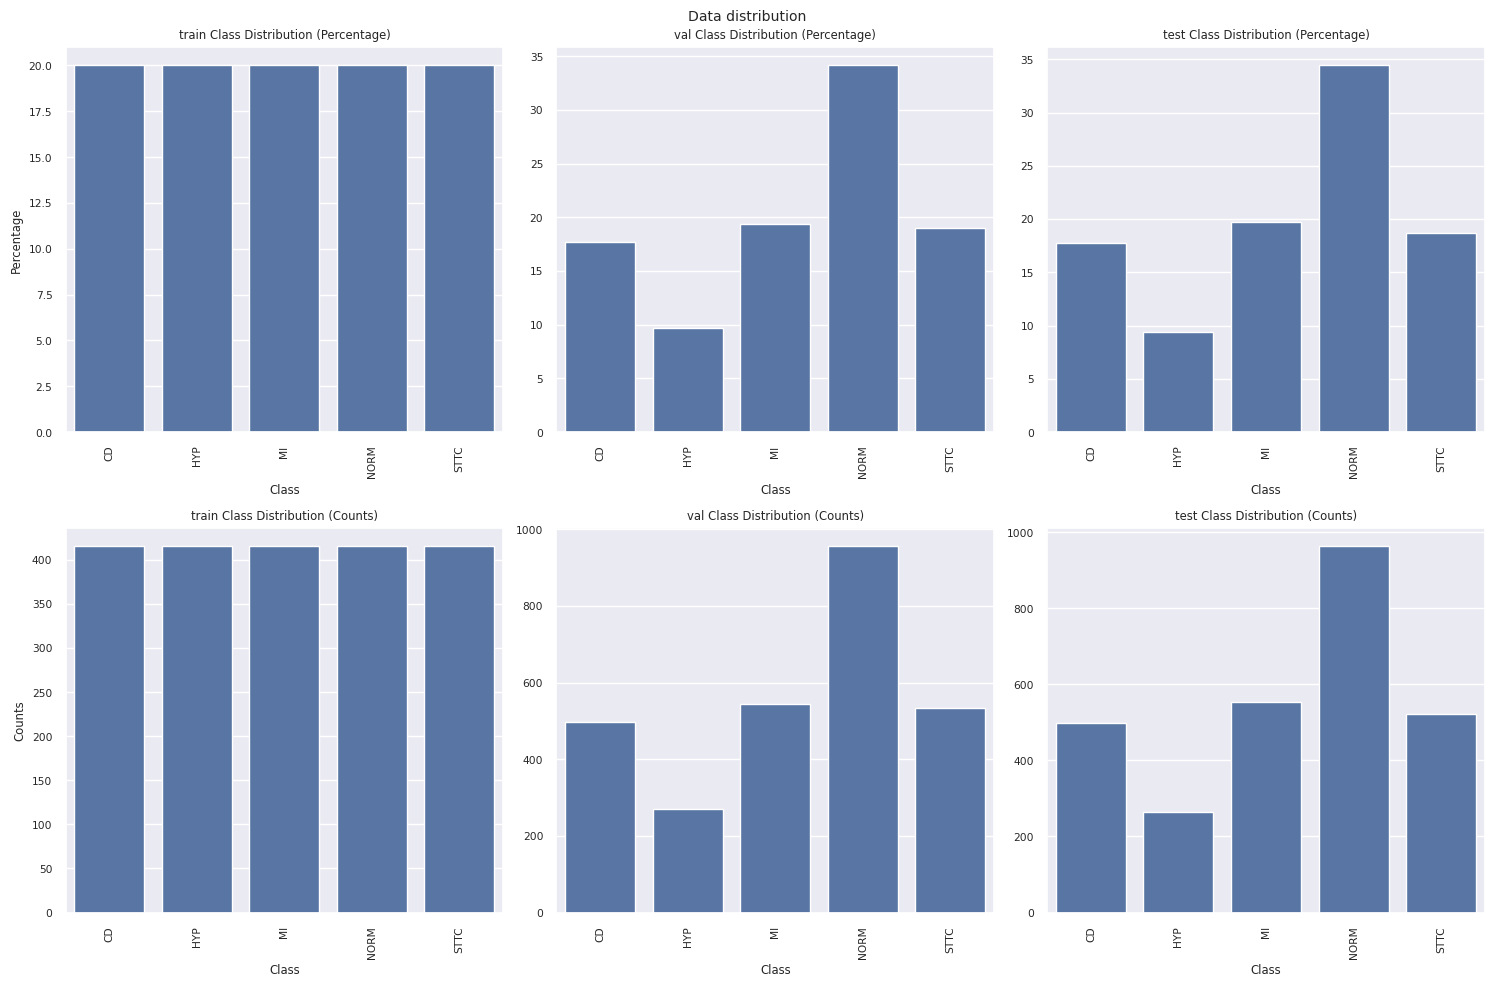

-- Single label under sampled and multi label


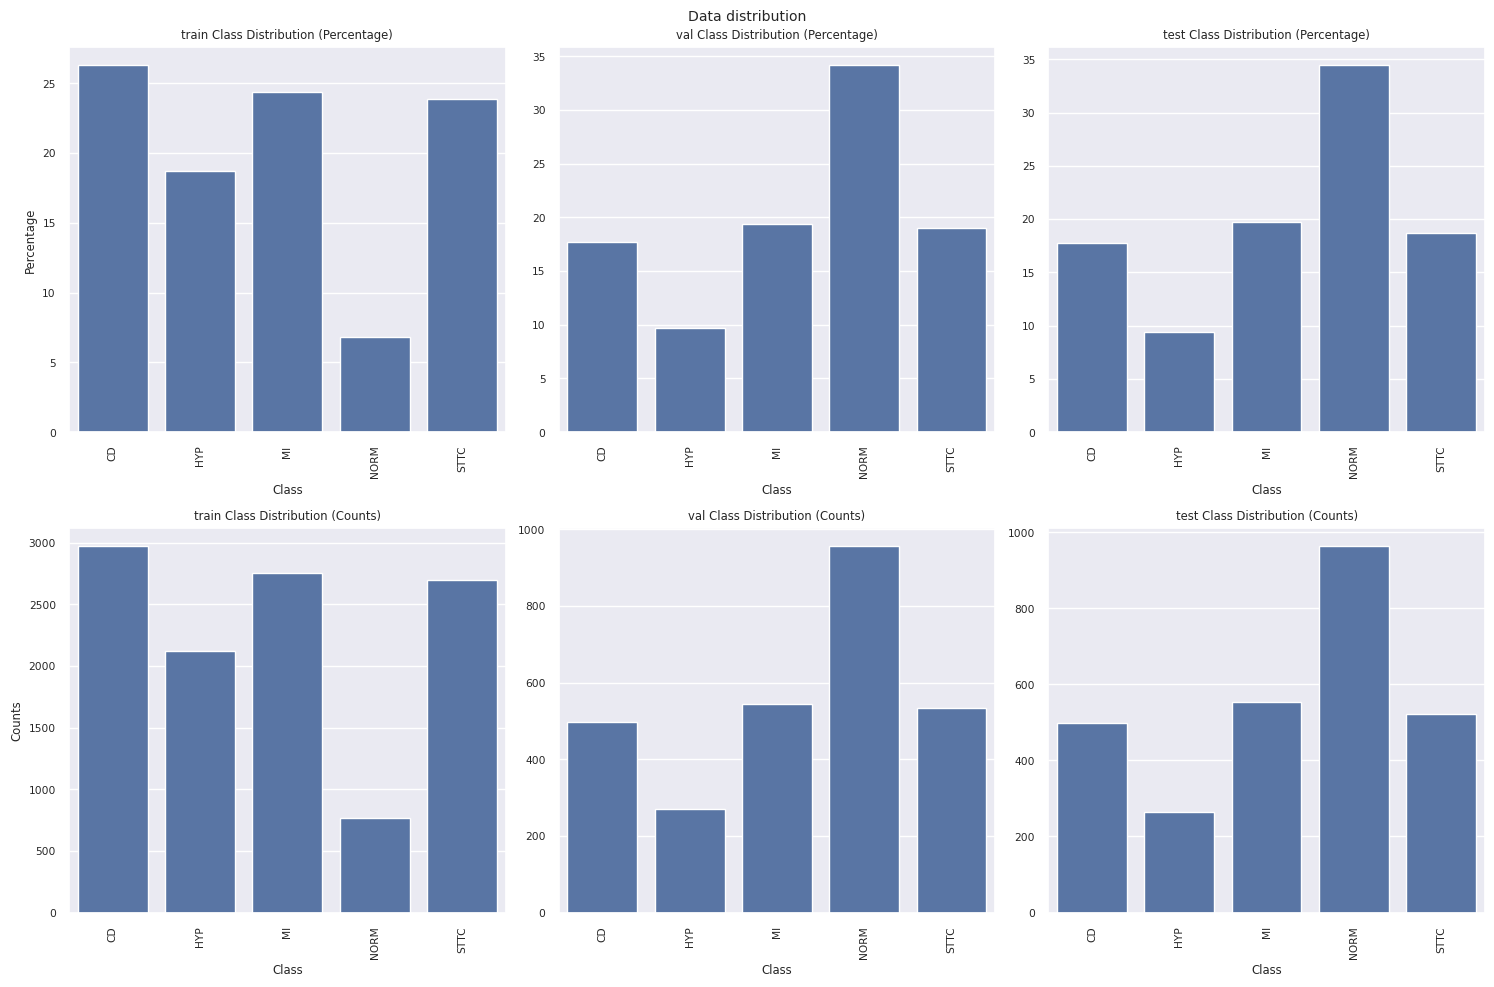

-- Single label over sampled


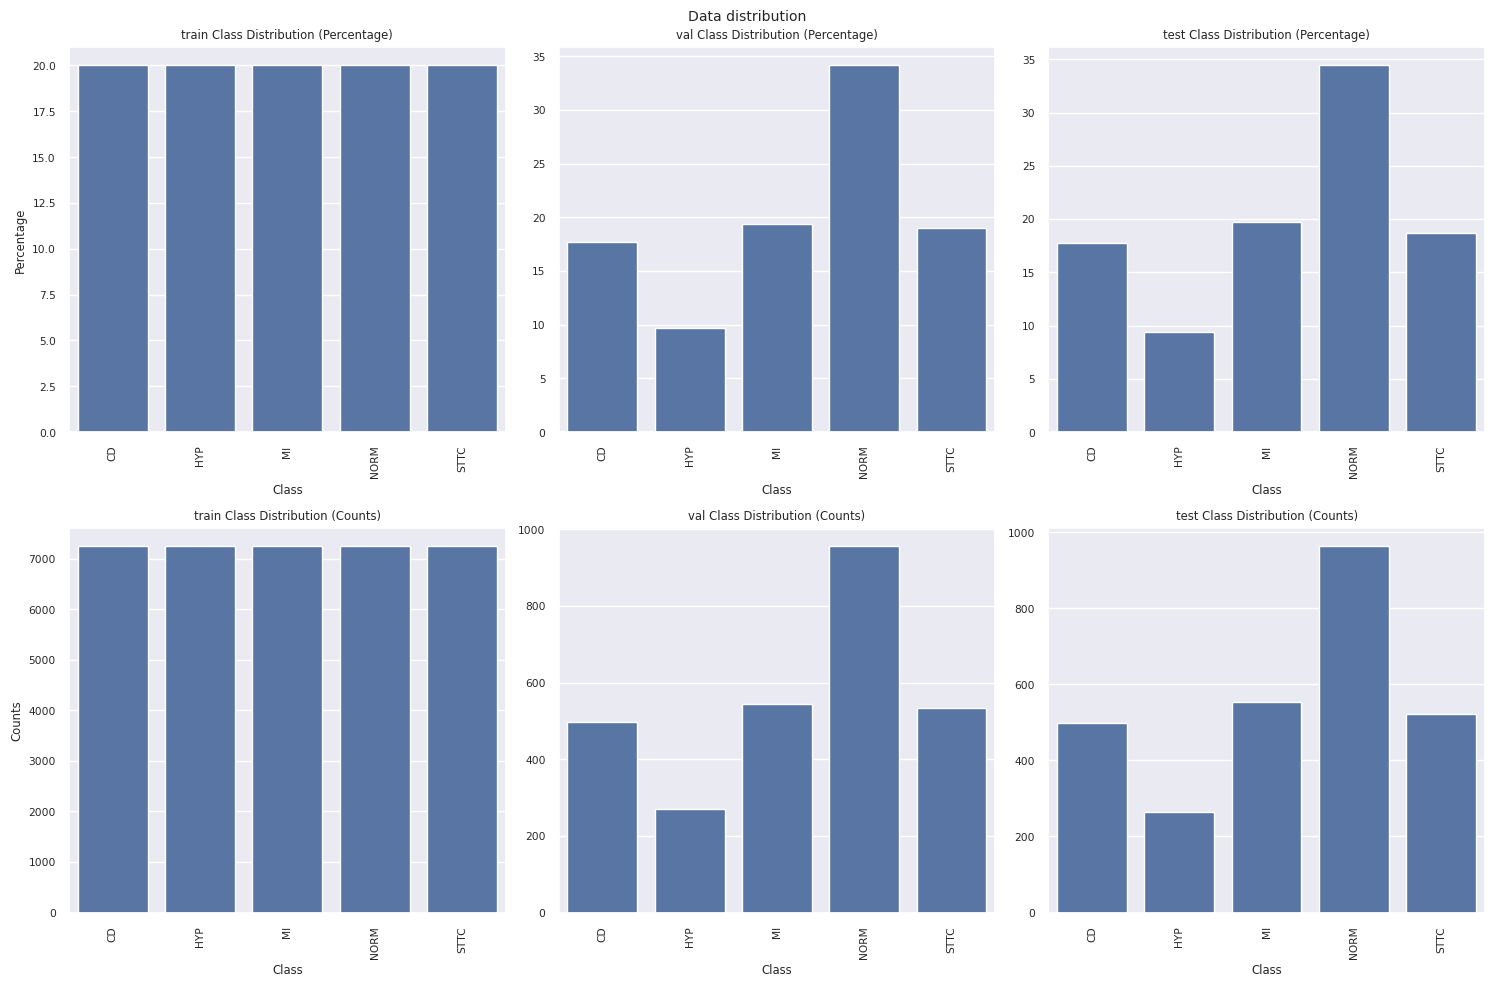

-- Single label over sampled and multi label


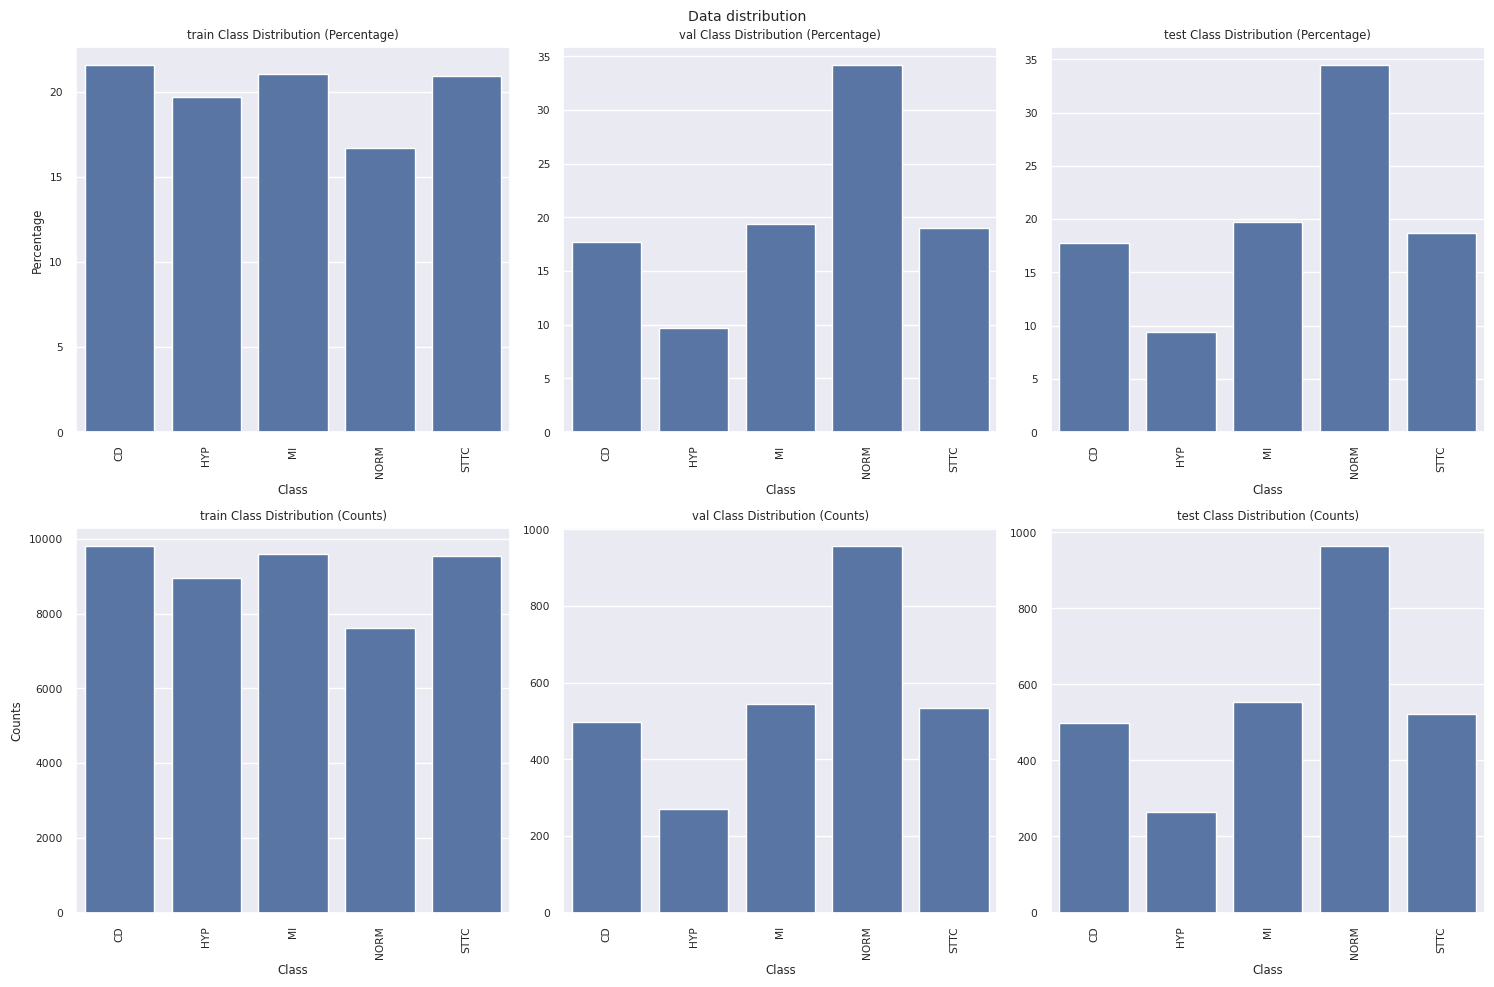

In [38]:
from data.data_augmentation import DataAugmentor
aug = DataAugmentor()

# Single label only
print('-- Single label only')
new_data, new_labels = aug.get_single_label_only(data["train"]["data"], data["train"]["labels"])
class_counts["train"], class_percentages["train"] = calculate_distribution(new_labels)
data_plots.plot_data_distribution(class_counts, class_percentages)

print('-- Multiple label only')
# Multi labels only
new_data, new_labels = aug.get_multi_label_only(data["train"]["data"], data["train"]["labels"])
class_counts["train"], class_percentages["train"] = calculate_distribution(new_labels)
data_plots.plot_data_distribution(class_counts, class_percentages)

print('-- Single label under sampled')
# Single label under sampled
new_data, new_labels = aug.get_undersampled(data["train"]["data"], data["train"]["labels"], add_multi=False)
class_counts["train"], class_percentages["train"] = calculate_distribution(new_labels)
data_plots.plot_data_distribution(class_counts, class_percentages)

print('-- Single label under sampled and multi label')
# Single label under sampled and multi label
new_data, new_labels = aug.get_undersampled(data["train"]["data"], data["train"]["labels"], add_multi=True)
class_counts["train"], class_percentages["train"] = calculate_distribution(new_labels)
data_plots.plot_data_distribution(class_counts, class_percentages)

print('-- Single label over sampled')
# Single label over sampled
new_data, new_labels = aug.get_oversampled(data["train"]["data"], data["train"]["labels"], add_multi=False)
class_counts["train"], class_percentages["train"] = calculate_distribution(new_labels)
data_plots.plot_data_distribution(class_counts, class_percentages)

print('-- Single label over sampled and multi label')
# Single label over sampled and multi label
new_data, new_labels = aug.get_oversampled(data["train"]["data"], data["train"]["labels"], add_multi=True)
class_counts["train"], class_percentages["train"] = calculate_distribution(new_labels)
data_plots.plot_data_distribution(class_counts, class_percentages)

Here displayed the training distribution of classes among the different configuration that will be use for training.

In [39]:
print('EDA completed')

EDA completed


## ML Classification


In [1]:
# Import Libraries

import logging

logger = logging.getLogger(__name__)
import random
import time
from datetime import datetime
from pathlib import Path
from typing import List, Union

import numpy as np
import torch
from sklearn.metrics import (accuracy_score, classification_report, f1_score, hamming_loss, jaccard_score,
                             precision_score, recall_score)

from data import dataset, dataloader
from evaluation import visualize as mlplots
from utils.utilities import EarlyStopping, balance_input
from utils.logger import setup_logging, log_resources, print_gpu_memory_usage, check_torch_cuda_installation

from models.architectures import FullyConvolutionalNetwork


**Check PyTorch - CUDA installation**

In [2]:
check_torch_cuda_installation(print_memory_usage = True)

Check torch-cuda installation: 
Cuda available:  True
	# CUDA devices:  1
	Current device:  0
	Device information:
		NVIDIA RTX 2000 Ada Generation Laptop GPU
	Memory usage for GPU: NVIDIA RTX 2000 Ada Generation Laptop GPU
		Allocated memory: 0.00 MB
		Reserved memory: 0.00 MB
		Max allocated memory: 0.00 MB
		Max reserved memory: 0.00 MB


#### Pipeline class

To give verbosity to the Notebook the `Pipeline` class, which manage the training, validation and test of the model has been copy-pasted from the `models/pipeline.py` file (it's redundant on porpouse). This part can be simply deleted and substituted with `from models.pipeline import Pipeline`

In [3]:
class Pipeline():

    def __init__(self, model: torch.nn.Module, labels_name: List, seed: int = 42, results_dir = None):
        """ Pipeline for model training and testing.

        Args:
            model (torch.nn.Module): Model
            labels_name (List[str]): Name of the labels
            seed (int, optional): Random seed. Default to 42.
        """

        self.model = model
        # results folder
        date = datetime.today().strftime('%Y_%m_%d')
        hour = datetime.today().strftime('%H_%M_%S')
        if results_dir:
            self.dst_dir =  Path(f"{results_dir}")
        else:
            self.dst_dir = Path(f"experiments/results/{date}/{hour}_{self.model.model_name}")
            if not self.dst_dir.exists():
                self.dst_dir.mkdir(parents=True, exist_ok=True)

        logger.info("Initiating model")

        # check if GPU is available
        self.use_cuda = torch.cuda.is_available()
        logger.info(f"GPU available: {self.use_cuda}")
        log_resources(logger)
        self.device = torch.device("cuda:0" if self.use_cuda else "cpu")
        if self.use_cuda:
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
            self.model.to(self.device)

        # fix all random seeds for reproducibility
        np.random.seed(seed)
        random.seed(seed)
        torch.manual_seed(seed)
        if self.use_cuda:
            torch.cuda.manual_seed(seed)
            torch.backends.cudnn.benchmark = False

        # model info
        logger.info(f"Model architecture: {self.model.model_name}")
        logger.info(f"Number of parameters: {sum(p.numel() for p in self.model.parameters()):.0f}")

        self.labels_name = labels_name
        self.num_classes = len(self.labels_name)

    def train(self,
              train_ds: dataset.ECGDataset,
              val_ds: dataset.ECGDataset,
              epochs: int,
              batch_size: int,
              lr: float,
              patience: int = 7,
              delta_stop: float = 0,
              val_every: int = 1,
              half_precision: bool = False) -> None:
        """ Train and evaluates a model

        Args:
            train_ds (ECGDataset): Training dataset
            val_ds (ECGDataset): Validation dataset
            epochs (int): Number of epochs
            batch_size (int): Batch size
            lr (float): Maximum learning rate
            patience (int, optional): Number of epochs before early stopping. Defaults to 7.
            delta_stop (float, optional): Minimum delta for early stopping. Defaults to 0.
            val_every (int, optional): Validation step every X epochs. Defaults to 1.
            half_precision(bool, optional): Train with half precision. Defaults to False.
        """

        logger.info("Training start")
        # setup the early stop
        early_stopping = EarlyStopping(patience=patience,
                                       delta=delta_stop,
                                       path=self.dst_dir.joinpath("checkpoint.pt"),
                                       logger=logger)

        # create the dataloaders
        class_weights = train_ds.class_weights
        train_loader = dataset.make_dataloader(ds=train_ds, batch_size=batch_size)
        val_loader = dataset.make_dataloader(ds=val_ds, batch_size=batch_size)

        # training setup
        optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer,
                                                        max_lr=lr,
                                                        steps_per_epoch=len(train_loader),
                                                        epochs=epochs)

        if class_weights is None:
            loss_fn = torch.nn.BCEWithLogitsLoss()
        else:
            loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights.to(self.device))

        predictions = []
        lr_evolution = []
        history = {"epoch": [], "train_time": [], "train_loss": [], "val_time": [], "val_loss": []}
        early_break = False
        val_step_counter = 0
        if half_precision:
            scaler = torch.cuda.amp.GradScaler()
            logger.info("Training with half-precision.")

        # Train and val loop
        for epoch in range(epochs):
            # train step
            train_loss = 0
            train_start = time.time()
            self.model.train()
            for param_group in optimizer.param_groups:
                lr_evolution.append(param_group['lr'])
            for data, target in train_loader:
                optimizer.zero_grad()
                if half_precision:
                    with torch.cuda.amp.autocast():
                        output = self.model(data.to(self.device))
                        loss = loss_fn(output, target.to(self.device))
                else:
                    output = self.model(data.to(self.device))
                    loss = loss_fn(output, target.to(self.device))

                train_loss += loss
                # if epoch%5==0 or epoch == 0:
                #     log_resources(logger)

                if half_precision:
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    loss.backward()
                    optimizer.step()

                scheduler.step()

            train_end = time.time()
            train_loss /= len(train_loader.dataset)

            # val step
            val_loss = 0
            val_start = time.time()
            self.model.eval()
            if val_step_counter % val_every == 0 or epoch == epochs - 1 or early_stopping.early_stop:
                val_step_counter = 0
                with torch.no_grad():
                    for data, target in val_loader:
                        output = self.model(data.to(self.device))

                        if epoch == epochs - 1 or early_stopping.early_stop:
                            predictions.append(torch.nn.functional.sigmoid(output))

                    val_loss += loss_fn(output, target.to(self.device))
                val_loss /= len(val_loader.dataset)
            else:
                val_step_counter += 1
            val_end = time.time()

            history["epoch"].append(1 + epoch)
            history["train_time"].append(train_end - train_start)
            history["train_loss"].append(train_loss.detach().cpu().item())
            history["val_time"].append(val_end - val_start)
            history["val_loss"].append(val_loss.detach().cpu().item())

            logger.info(", ".join([f"{k}: {v[-1]:.6f}" for k, v in history.items()]))

            if early_break:
                break

            early_stopping(val_loss, self.model)
            if early_stopping.early_stop:
                early_break = early_stopping.early_stop

        if early_stopping.early_stop:
            early_stopping.load_checkpoint(self.model)

        mlplots.plot_loss_evolution(history["train_loss"], history["val_loss"], dst_dir=self.dst_dir, show=False)

        total_time_min = sum(history["train_time"]) / 60
        logger.info(f"Total training time: {total_time_min:.2f} minutes")

        mlplots.plot_lr_evolution(lrs=lr_evolution, dst_dir=self.dst_dir, show=False)

        # metrics
        predictions = torch.cat(predictions).detach().cpu().numpy()

        self.val_thresholds = mlplots.plot_pr_curves(ground_truth=val_ds.labels_bin,
                                                     predictions=predictions,
                                                     labels_name=self.labels_name,
                                                     data_type="val",
                                                     dst_dir=self.dst_dir,
                                                     show=False)
        logger.info(f"Thresholds: {self.val_thresholds}")
        self.val_thresholds = np.array([self.val_thresholds[l] for l in self.labels_name])
        predictions = (predictions > self.val_thresholds).astype(int)

        mlplots.plot_cm_multilabel(ground_truth=val_ds.labels_bin,
                                   predictions=predictions,
                                   labels_name=self.labels_name,
                                   data_type="val",
                                   dst_dir=self.dst_dir,
                                   show=False)

        self.report(val_ds.labels_bin, predictions, self.labels_name)

    def evaluate(self,
              test_ds: dataset.ECGDataset,
              batch_size: int,) -> None:

        """
        Evaluates a trained model on a test dataset.

        Args:
            test_ds (ECGDataset): The test dataset to evaluate the model on.
            batch_size (int): The number of samples per batch to load.
        """
        
        test_loader = dataset.make_dataloader(ds=test_ds, batch_size=batch_size)

        test_start = time.time()
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for data, target in test_loader:
                output = self.model(data.to(self.device))
                predictions.append(torch.nn.functional.sigmoid(output))

        test_end = time.time()
         # metrics
        predictions = torch.cat(predictions).detach().cpu().numpy()

        self.test_thresholds = mlplots.plot_pr_curves(ground_truth=test_ds.labels_bin,
                                                     predictions=predictions,
                                                     labels_name=self.labels_name,
                                                     data_type="test",
                                                     dst_dir=self.dst_dir,
                                                     show=False)
        
        logger.info(f"Thresholds: {self.test_thresholds}")
        self.test_thresholds = np.array([self.test_thresholds[l] for l in self.labels_name])
        predictions = (predictions > self.test_thresholds).astype(int)

        mlplots.plot_cm_multilabel(ground_truth=test_ds.labels_bin,
                                   predictions=predictions,
                                   labels_name=self.labels_name,
                                   data_type="test",
                                   dst_dir=self.dst_dir,
                                   show=False)

        self.report(test_ds.labels_bin, predictions, self.labels_name)



    def predict(self, test_ds: dataset.ECGDataset, batch_size: int = 512, logits: bool = False) -> np.ndarray:
        """
        Predicts the classes from a given ECG dataset.

        Args:
            test_ds (ECGDataset): The test dataset containing ECG signals.
            batch_size (int, optional): The number of samples per batch to load. Defaults to 512.
            logits (bool, optional): If True, returns the raw logits instead of probabilities. Defaults to False.

        Returns:
            np.ndarray: The model's predictions as a numpy array.
        """

        # Create a DataLoader for the test dataset
        pred_loader = dataset.make_dataloader(ds=test_ds, batch_size=batch_size)

        self.model.eval()
        predictions = []
        with torch.no_grad():
            for data in pred_loader:
                output = self.model(data.to(self.device))
                if logits:
                    predictions.append(output)
                else:
                    predictions.append(torch.nn.functional.sigmoid(output))
        
        predictions = torch.cat(predictions).detach().cpu().numpy()

        return predictions


    def report(self, y_true, y_pred, label_names):

        # micro: averages metrics across all classes, emphasizing overall performance
        # macro: averages metrics independently for each class, giving equal weight to each class
        accuracy = accuracy_score(y_true, y_pred)

        # proportion of predicted positive cases that are actually positive across all classes
        precision_micro = precision_score(y_true, y_pred, average='micro')
        precision_macro = precision_score(y_true, y_pred, average='macro')
        precision_weighted = precision_score(y_true, y_pred, average='weighted')
        # proportion of actual positive cases that are correctly predicted as positive across all classes
        recall_micro = recall_score(y_true, y_pred, average='micro')
        recall_macro = recall_score(y_true, y_pred, average='macro')
        recall_weighted = recall_score(y_true, y_pred, average='weighted')

        f1_micro = f1_score(y_true, y_pred, average='micro')
        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_weighted = f1_score(y_true, y_pred, average='weighted')

        # measures the fraction of labels that are incorrectly predicted
        h_loss = hamming_loss(y_true, y_pred)

        # measures similarity between the predicted and true label sets
        jaccard = jaccard_score(y_true, y_pred, average='samples')

        class_report = classification_report(y_true, y_pred, target_names=label_names, zero_division=0)

        logger.info("Overall Metrics:")
        logger.info(f"Accuracy: {accuracy:.3f} (higher is better)")
        logger.info(f"Precision (Micro): {precision_micro:.3f} (higher is better)")
        logger.info(f"Precision (Macro): {precision_macro:.3f} (higher is better)")
        logger.info(f"Precision (Weighted): {precision_weighted:.3f} (higher is better)")
        logger.info(f"Recall (Micro): {recall_micro:.3f} (higher is better)")
        logger.info(f"Recall (Macro): {recall_macro:.3f} (higher is better)")
        logger.info(f"Recall (Weighted): {recall_weighted:.3f} (higher is better)")
        logger.info(f"F1-Score (Micro): {f1_micro:.3f} (higher is better)")
        logger.info(f"F1-Score (Macro): {f1_macro:.3f} (higher is better)")
        logger.info(f"F1-Score (Weighted): {f1_weighted:.3f} (higher is better)")
        logger.info(f"Hamming Loss: {h_loss:.3f} (lower is better)")
        logger.info(f"Jaccard Score: {jaccard:.3f} (higher is better)")

        logger.info(f"Classification Report:\n{class_report}")

        


#### Load Data 

In [4]:
logger.info("Loading data...")
data = dataloader.load_data(
    data_path= '../data/ptbxl/',
    sampling_rate=100)
logger.info("Data loaded.")

**Dataset splits setup**

In [5]:
# Define the datasets
aug_type = None
train_ds = dataset.ECGDataset(data=data, apply_sampler=False, ds_type="train", shuffle=True, augmentation=aug_type)
val_ds = dataset.ECGDataset(data=data, apply_sampler=False, ds_type="val", shuffle=True)
test_ds = dataset.ECGDataset(data=data, apply_sampler=False, ds_type="test")
print('Dataset dim:')
for name, ds in zip(['train','val','test'], [train_ds, val_ds, test_ds]):
    print(f"\t{name}: {len(ds)}")

Dataset dim:
	train: 17111
	val: 2156
	test: 2156


### Train a model

**Hyperparameters setup**

In [8]:
logger = setup_logging("training_pipeline.log")

# Model config
filters = [128, 256, 128]
kernel_sizes = [8, 5, 3]
linear_layer_len = 128

# Training Hyperparameters
epochs = 50
batch_size = 128
learning_rate = 0.001
sampling_rate = 100
patience= 10
delta_stop= 0
val_every= 1
half_precision= False
aug_type = None # [None, "under", "over"] for standard, oversampling or undersampling experiments 
                # (can also be runned in a for loop to do the experiments in an automatic way --> train.py)


**Import network and define the Pipeline**

In [11]:

model = FullyConvolutionalNetwork(num_classes=train_ds.num_classes,
                                  channels=train_ds.channels,
                                  filters=filters,
                                  kernel_sizes=kernel_sizes,
                                  linear_layer_len=linear_layer_len)

pipe = Pipeline(model=model, labels_name=train_ds.labels_class)


2024-08-09 13:17:13,310 - root - INFO - Initiating model
2024-08-09 13:17:13,310 - root - INFO - Initiating model
2024-08-09 13:17:13,312 - root - INFO - GPU available: True
2024-08-09 13:17:13,312 - root - INFO - GPU available: True
2024-08-09 13:17:14,377 - root - INFO - CPU Usage: 0.0%
2024-08-09 13:17:14,377 - root - INFO - CPU Usage: 0.0%
2024-08-09 13:17:14,418 - root - INFO - Memory Usage: 39.8% (Available: 9.29 GB)
2024-08-09 13:17:14,418 - root - INFO - Memory Usage: 39.8% (Available: 9.29 GB)
2024-08-09 13:17:14,435 - root - INFO - GPU 0 - Usage: 0.00%, Memory Usage: 0.00% (Free: 0.00 GB)
2024-08-09 13:17:14,435 - root - INFO - GPU 0 - Usage: 0.00%, Memory Usage: 0.00% (Free: 0.00 GB)
2024-08-09 13:17:15,563 - root - INFO - Model architecture: FullyConvolutionalNetwork
2024-08-09 13:17:15,563 - root - INFO - Model architecture: FullyConvolutionalNetwork
2024-08-09 13:17:15,576 - root - INFO - Number of parameters: 309765
2024-08-09 13:17:15,576 - root - INFO - Number of param

**Start the training**

2024-08-09 13:18:39,291 - root - INFO - Training start
2024-08-09 13:18:39,291 - root - INFO - Training start
/usr/local/lib/python3.10/site-packages/torch/nn/modules/conv.py:304: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(input, weight, bias, self.stride,
2024-08-09 13:18:51,101 - root - INFO - epoch: 1.000000, train_time: 10.852873, train_loss: 0.005064, val_time: 0.293639, val_loss: 0.000265
2024-08-09 13:18:51,101 - root - INFO - epoch: 1.000000, train_time: 10.852873, train_loss: 0.005064, val_time: 0.293639, val_loss: 0.000265
2024-08-09 13:18:51,104 - root - INFO - Reset counter and saving model...
2024-08-09 13:18:51,104 - root - INFO - Reset counter and saving model...
2024-08-09 13:18:58,018 - root - INFO - epoch: 2.000000, train_time: 6.579867, train_loss: 0.004473, val_time: 0.294164, val_loss: 0.00

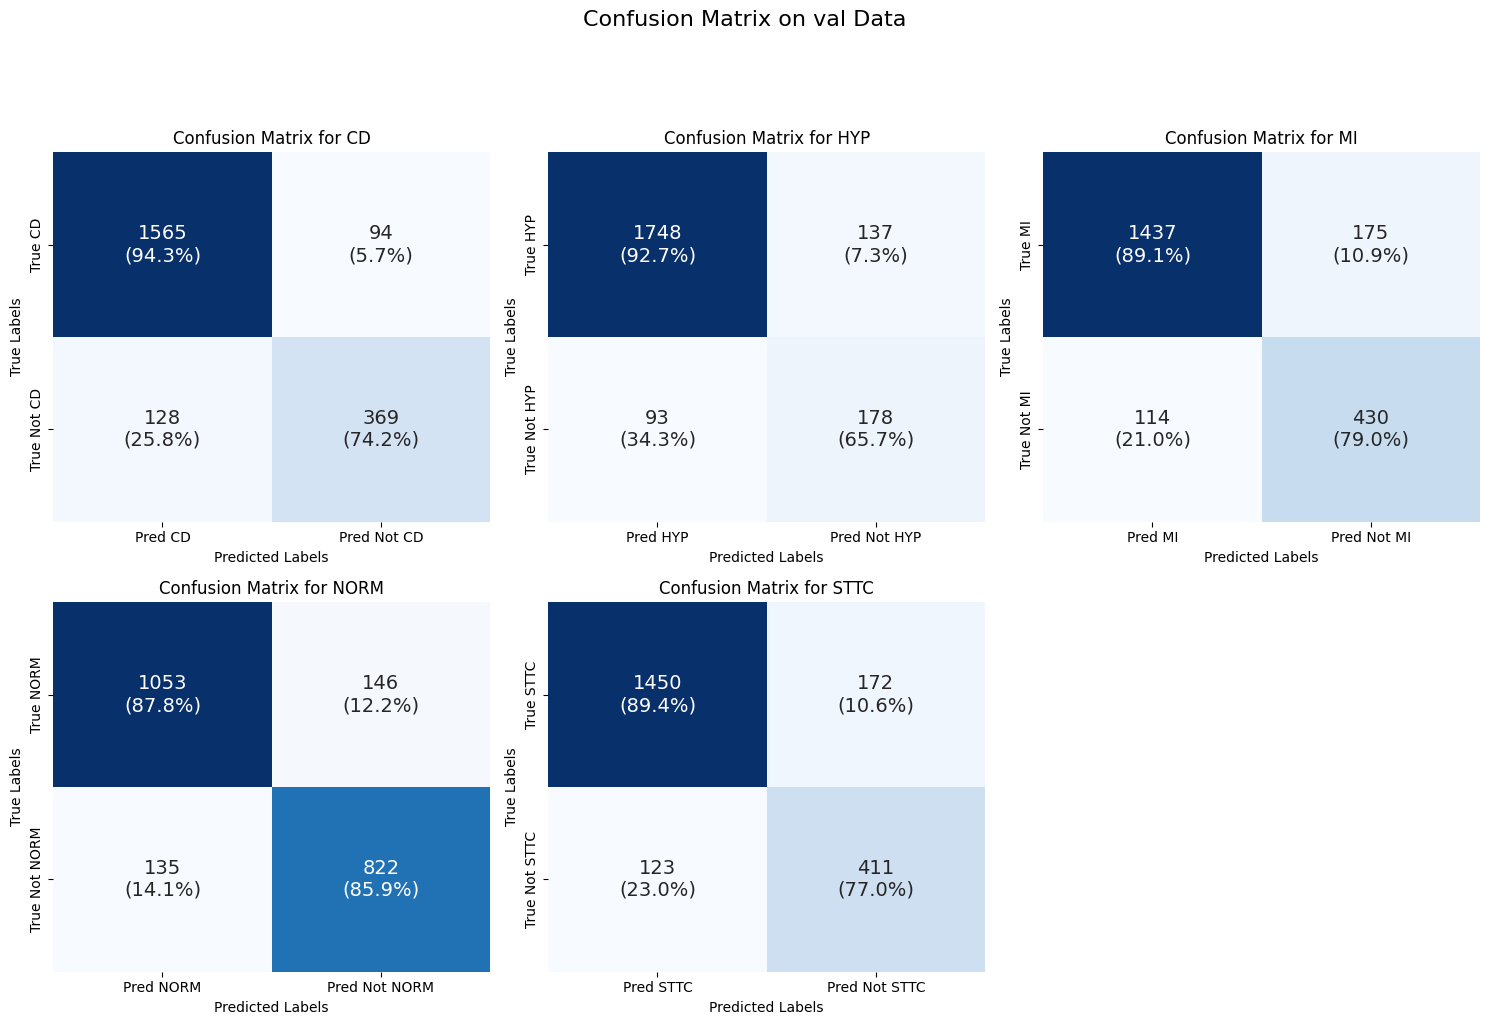

In [12]:
# print_gpu_memory_usage()
pipe.train(train_ds=train_ds,
           val_ds=val_ds,
           epochs=epochs,
           batch_size=batch_size,
           lr=learning_rate,
           patience=patience,
           delta_stop=delta_stop,
           val_every=val_every,
           half_precision=half_precision)

**Evaluate on test set**

2024-08-09 13:23:01,238 - root - INFO - Thresholds: {'CD': np.float32(0.22869356), 'HYP': np.float32(0.11488941), 'MI': np.float32(0.34496307), 'NORM': np.float32(0.42293033), 'STTC': np.float32(0.47474504)}
2024-08-09 13:23:01,238 - root - INFO - Thresholds: {'CD': np.float32(0.22869356), 'HYP': np.float32(0.11488941), 'MI': np.float32(0.34496307), 'NORM': np.float32(0.42293033), 'STTC': np.float32(0.47474504)}
2024-08-09 13:23:01,860 - root - INFO - Overall Metrics:
2024-08-09 13:23:01,860 - root - INFO - Overall Metrics:
2024-08-09 13:23:01,863 - root - INFO - Accuracy: 0.597 (higher is better)
2024-08-09 13:23:01,863 - root - INFO - Accuracy: 0.597 (higher is better)
2024-08-09 13:23:01,865 - root - INFO - Precision (Micro): 0.731 (higher is better)
2024-08-09 13:23:01,865 - root - INFO - Precision (Micro): 0.731 (higher is better)
2024-08-09 13:23:01,867 - root - INFO - Precision (Macro): 0.705 (higher is better)
2024-08-09 13:23:01,867 - root - INFO - Precision (Macro): 0.705 (hi

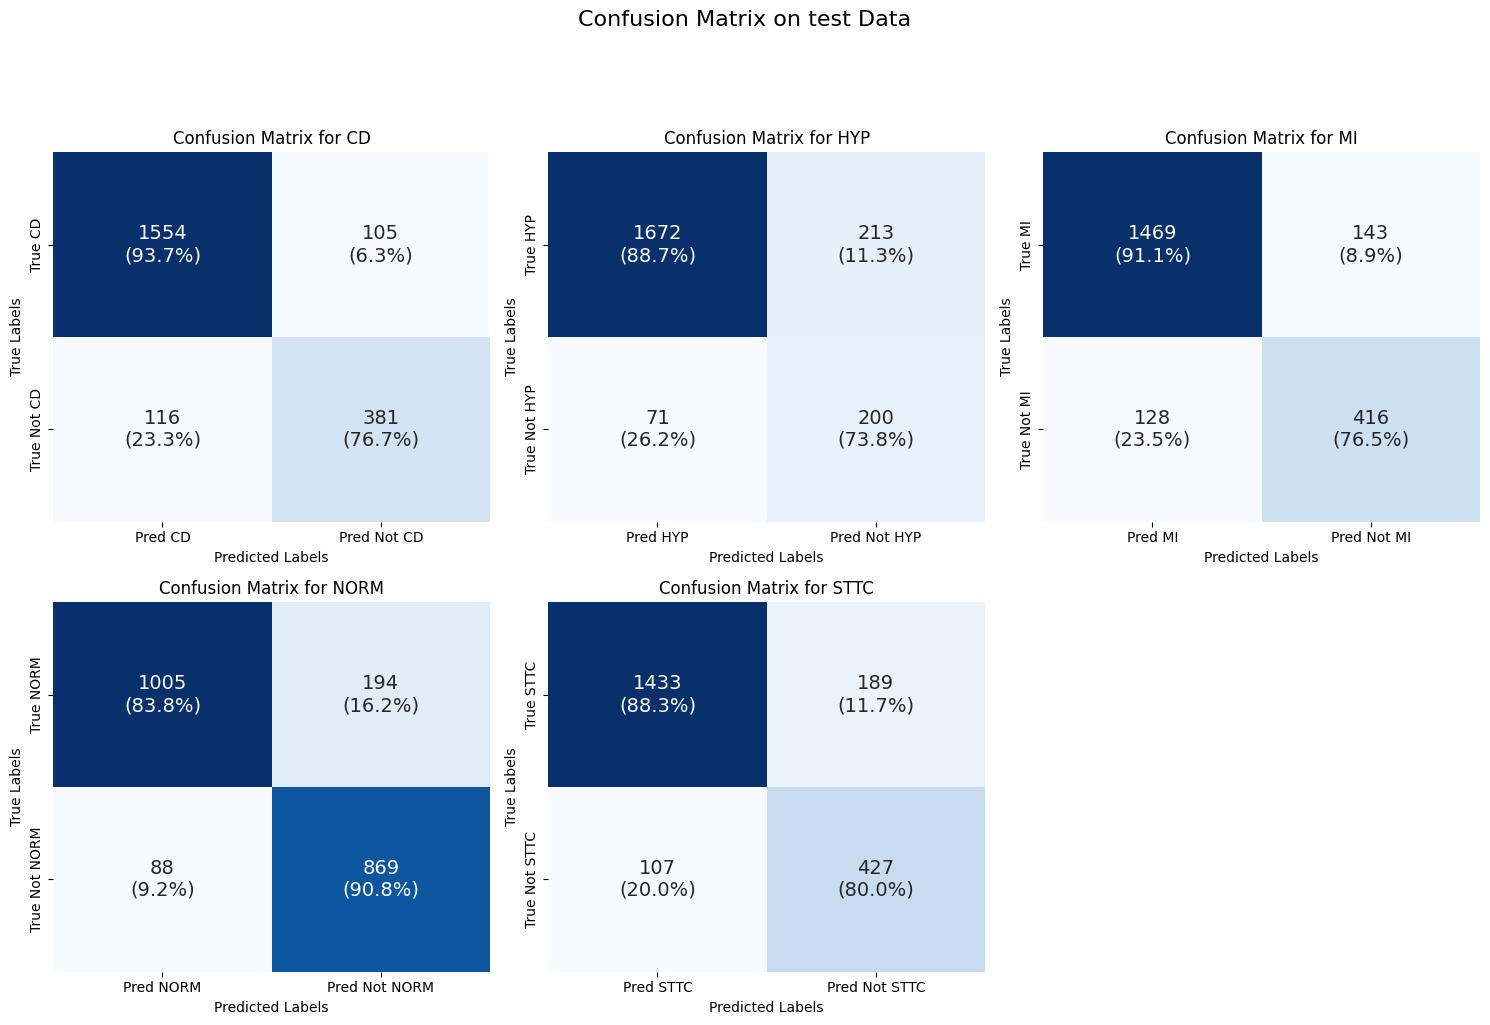

In [13]:
pipe.evaluate(test_ds = test_ds, batch_size = 64)

### Load a pretrained model & evaluate

In [14]:
test_ds = dataset.ECGDataset(data=data, apply_sampler=False, ds_type="test")
print('Dataset dim: ', len(test_ds))

Dataset dim:  2156


In [15]:
results_path = 'experiments/results/' +'2024_08_09/11_27_31_FullyConvolutionalNetwork/' # select your model folder_path
model = FullyConvolutionalNetwork(num_classes=test_ds.num_classes,
                                  channels=test_ds.channels,
                                  filters=[128, 256, 128],
                                  kernel_sizes=[8, 5, 3],
                                  linear_layer_len=128)
model.load_state_dict(torch.load(results_path + 'checkpoint.pt'))

/tmp/ipykernel_3653/2525460352.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(results_path + 'checkpoint.pt'))


<All keys matched successfully>

Evaluate on test data

2024-08-09 13:23:08,838 - root - INFO - Initiating model
2024-08-09 13:23:08,838 - root - INFO - Initiating model
2024-08-09 13:23:08,840 - root - INFO - GPU available: True
2024-08-09 13:23:08,840 - root - INFO - GPU available: True
2024-08-09 13:23:09,987 - root - INFO - CPU Usage: 0.0%
2024-08-09 13:23:09,987 - root - INFO - CPU Usage: 0.0%
2024-08-09 13:23:09,989 - root - INFO - Memory Usage: 55.0% (Available: 6.95 GB)
2024-08-09 13:23:09,989 - root - INFO - Memory Usage: 55.0% (Available: 6.95 GB)
2024-08-09 13:23:09,991 - root - INFO - GPU 0 - Usage: 0.00%, Memory Usage: 29.38% (Free: 0.00 GB)
2024-08-09 13:23:09,991 - root - INFO - GPU 0 - Usage: 0.00%, Memory Usage: 29.38% (Free: 0.00 GB)
2024-08-09 13:23:10,012 - root - INFO - Model architecture: FullyConvolutionalNetwork
2024-08-09 13:23:10,012 - root - INFO - Model architecture: FullyConvolutionalNetwork
2024-08-09 13:23:10,015 - root - INFO - Number of parameters: 309765
2024-08-09 13:23:10,015 - root - INFO - Number of par

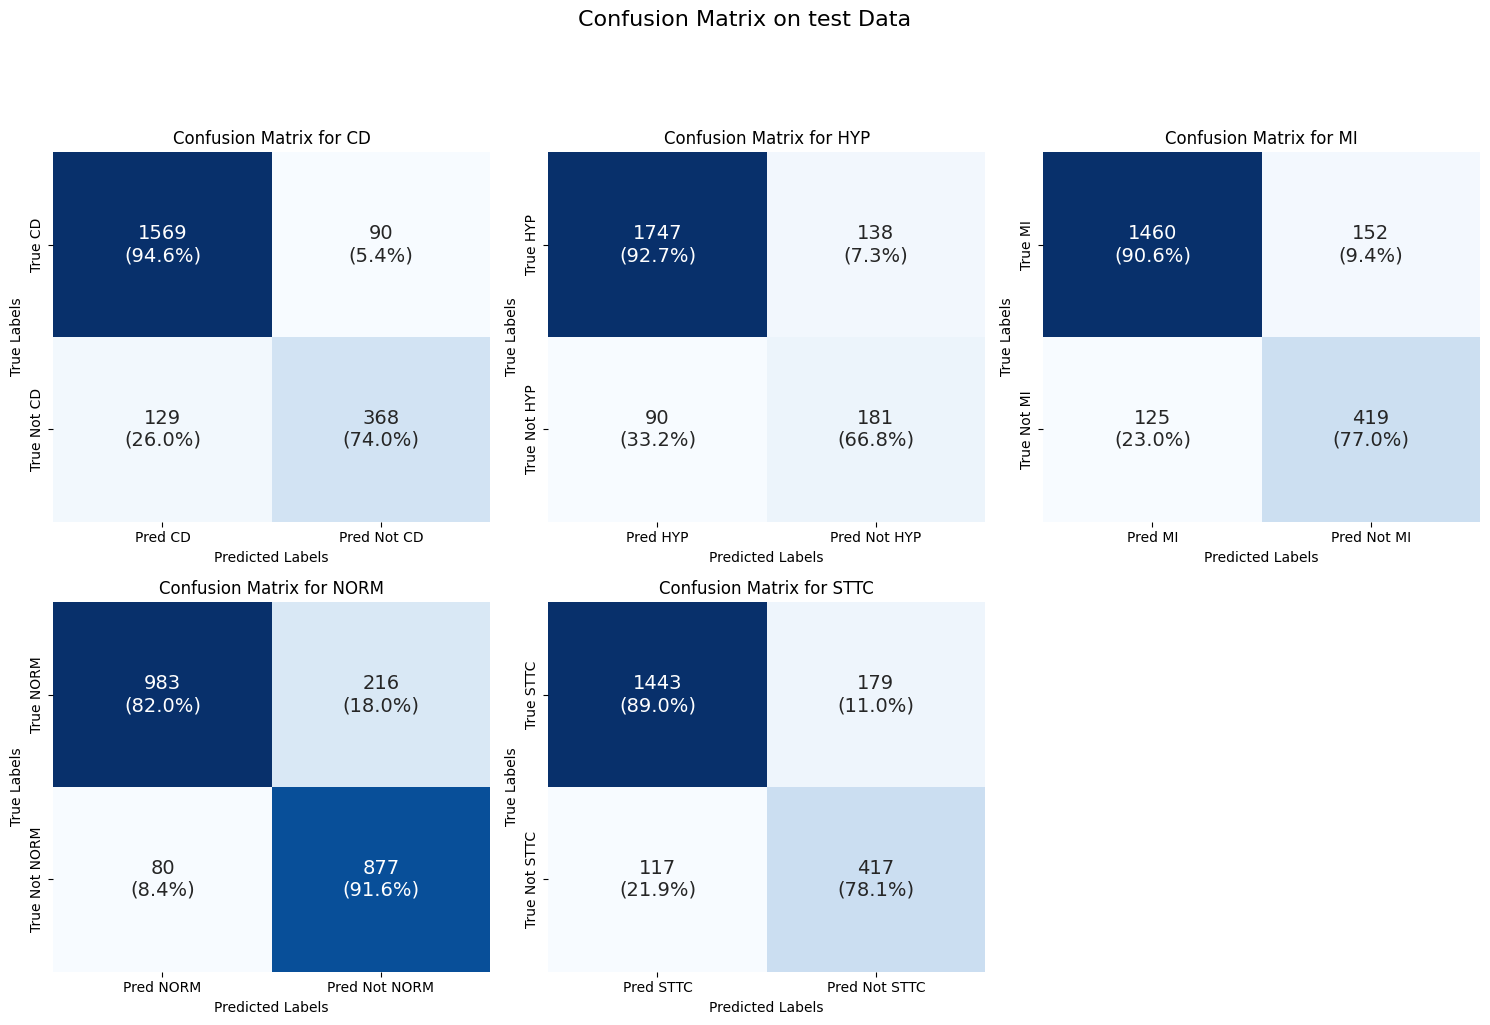

In [16]:
# Init the pipeline
pipe = Pipeline(model=model, labels_name=test_ds.labels_class, results_dir = results_path)
pipe.evaluate(test_ds = test_ds, batch_size = 64)

## Plot the results of a selected experiment:
- Training and Validation losses
- Learning Rate values
- Correlation matrices for validation and test sets
- Precision-Recall curves for validation and test sets

File name: loss_evolution.png


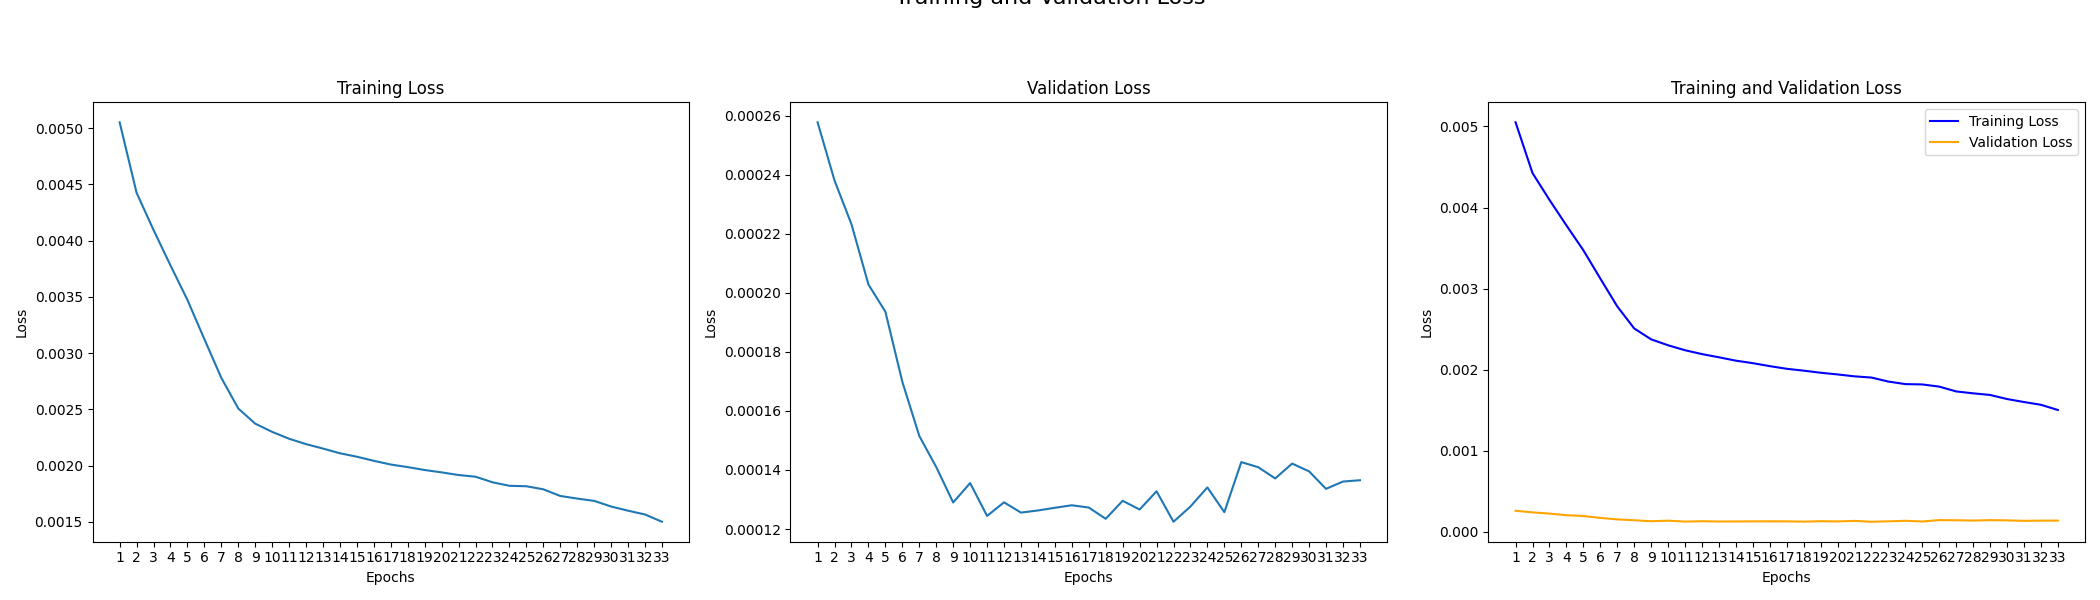

File name: lr_evolution.png


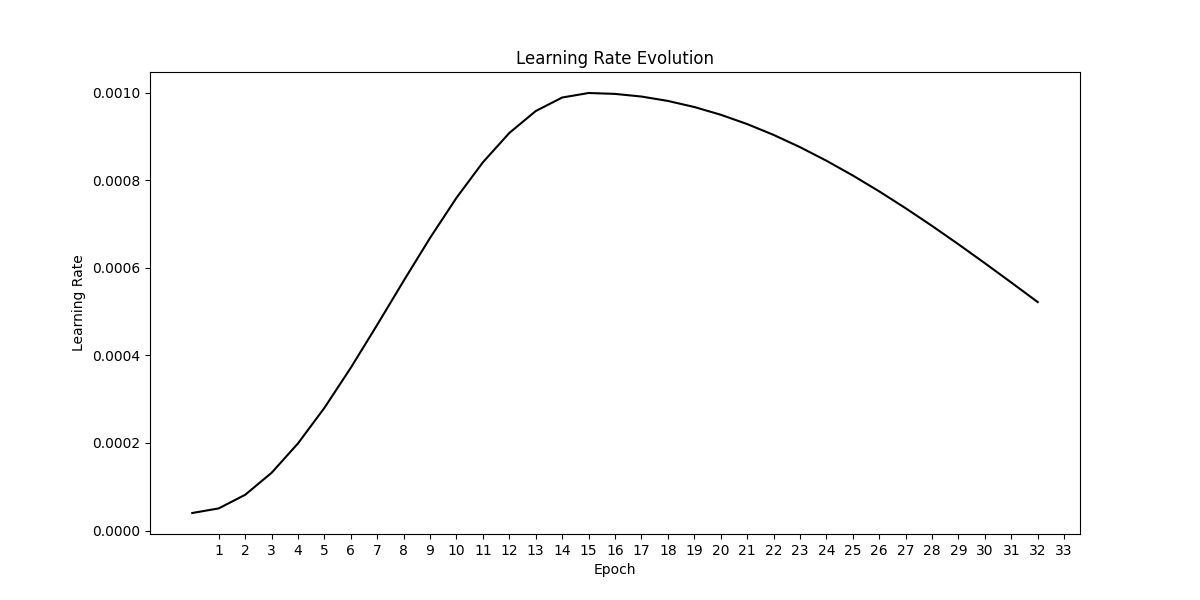

File name: test_confusion_matrices.png


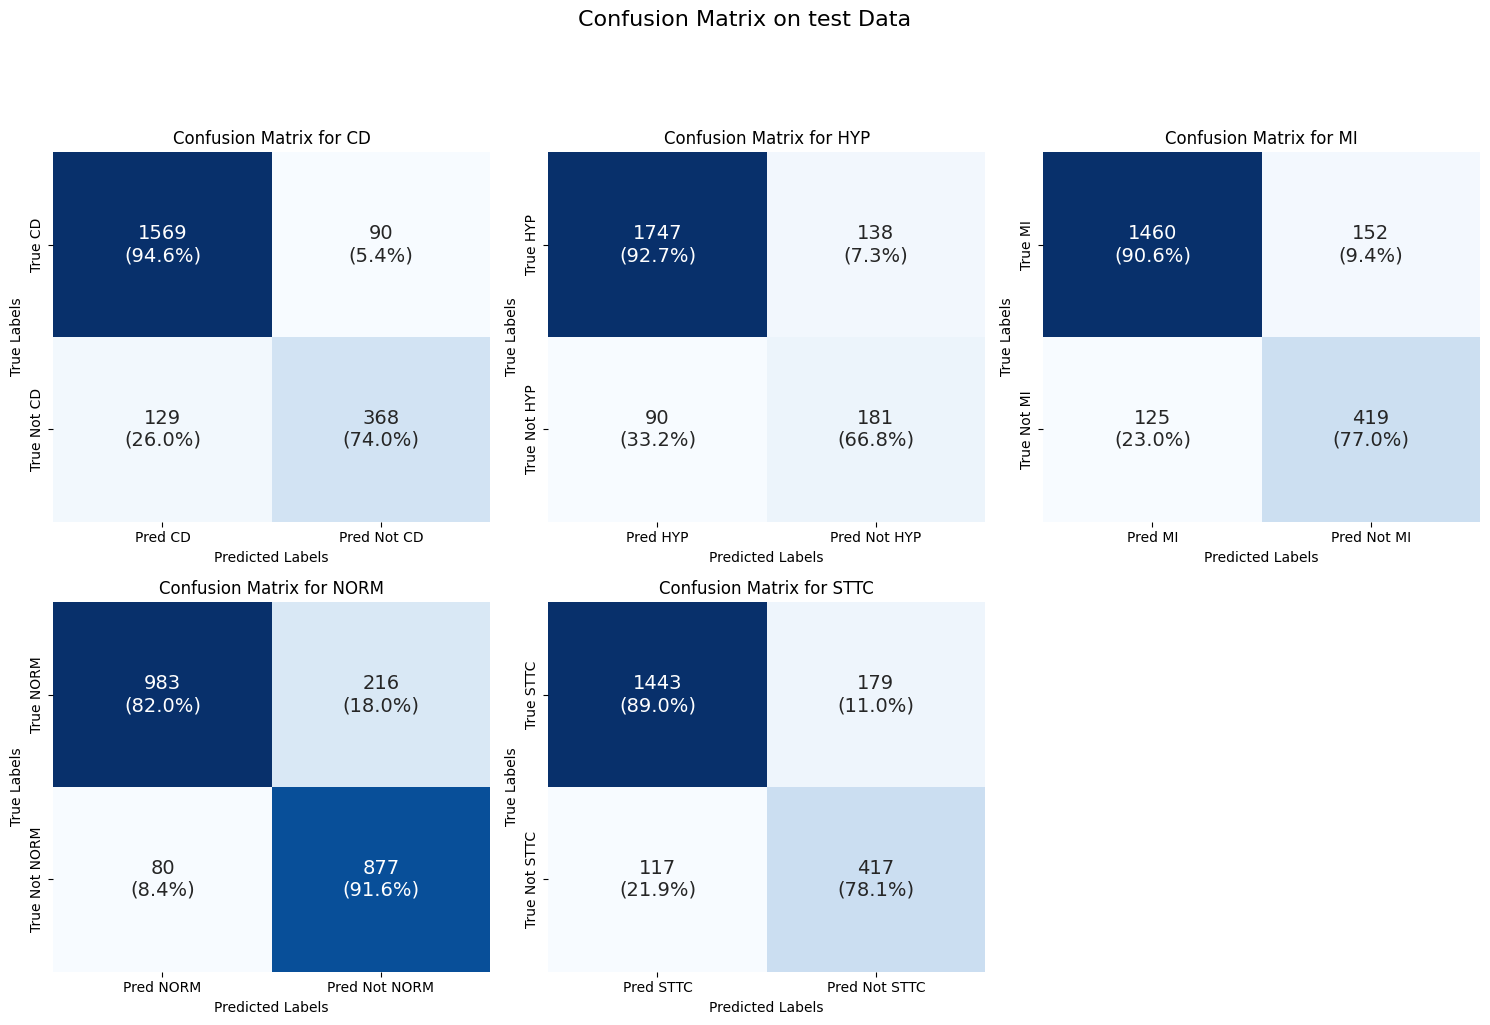

File name: test_pr_curves.png


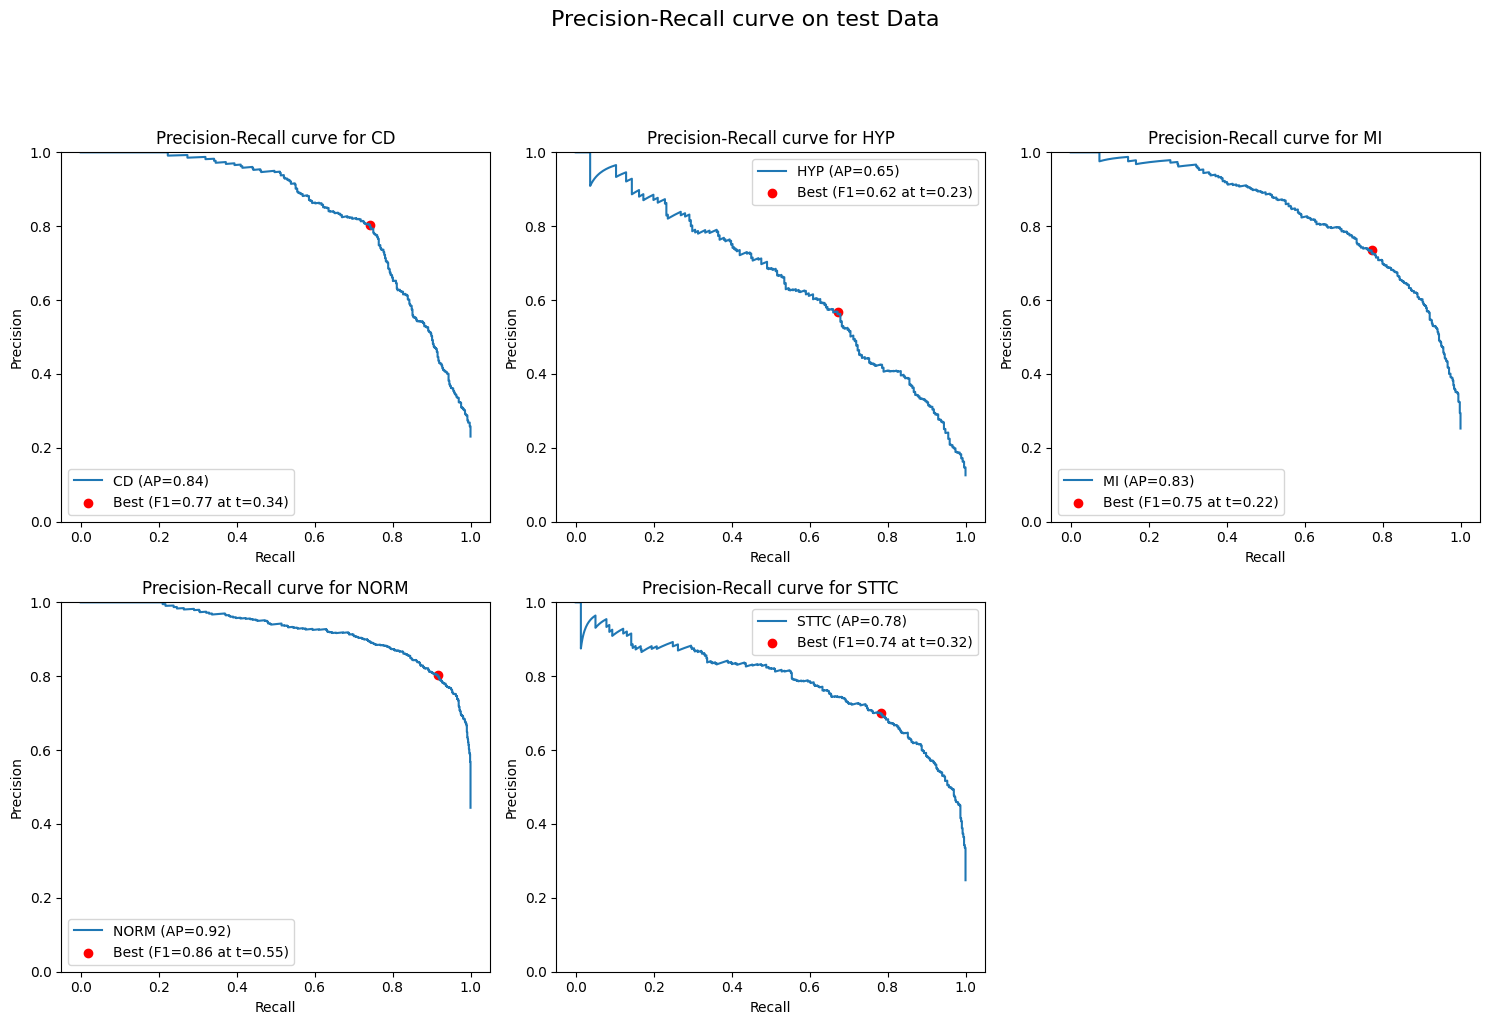

File name: val_confusion_matrices.png


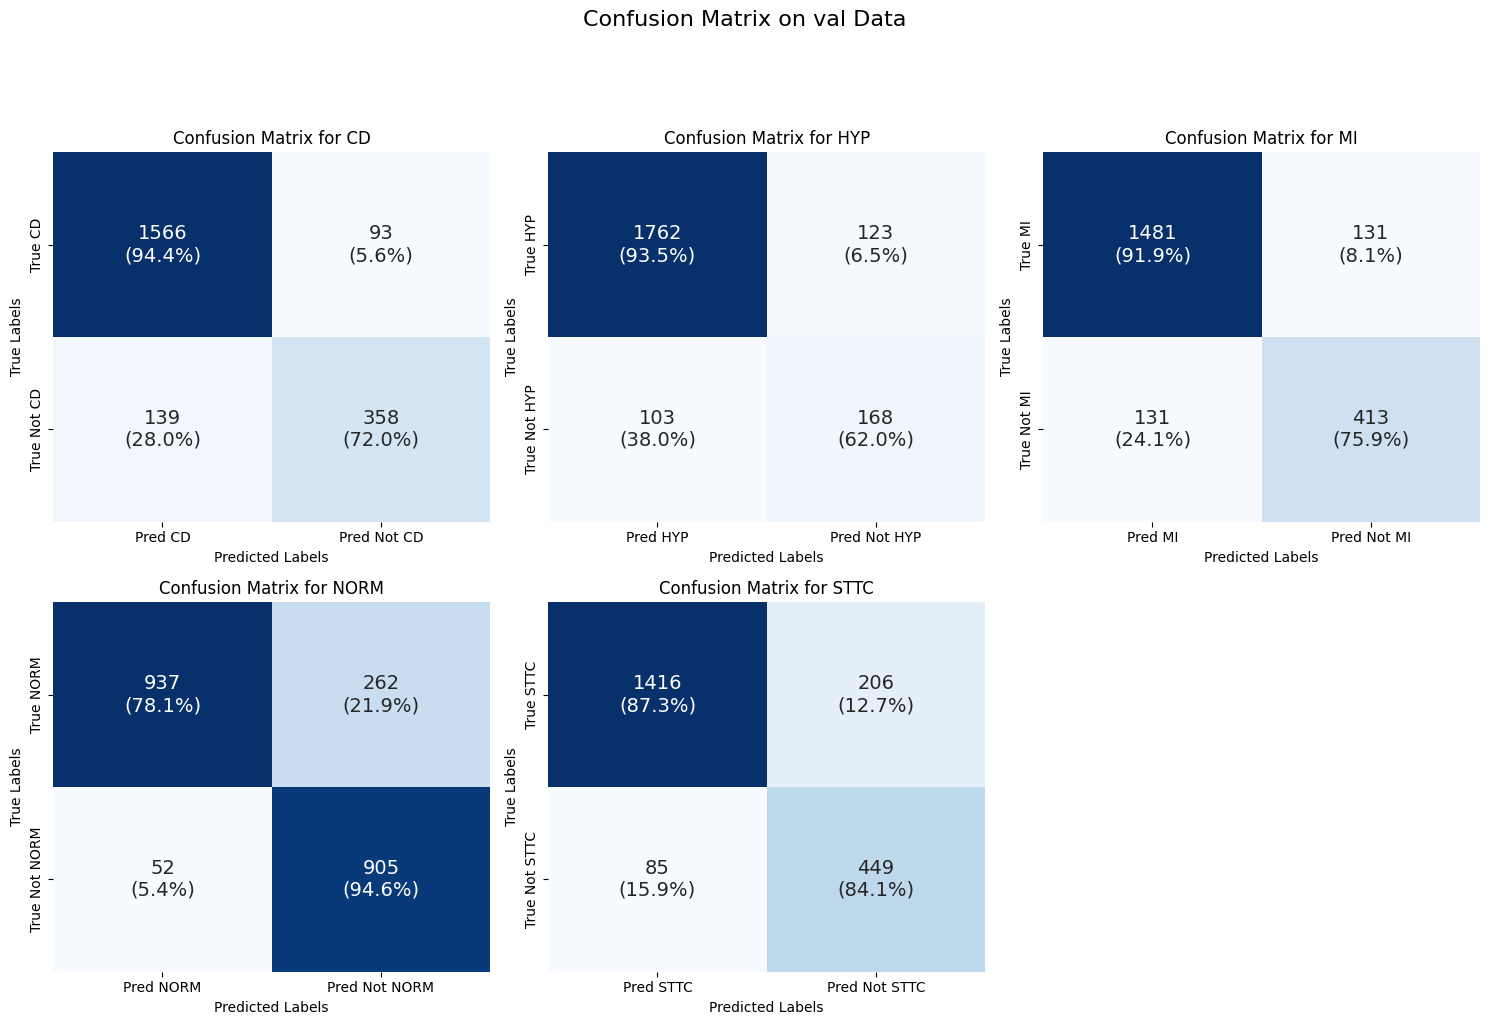

File name: val_pr_curves.png


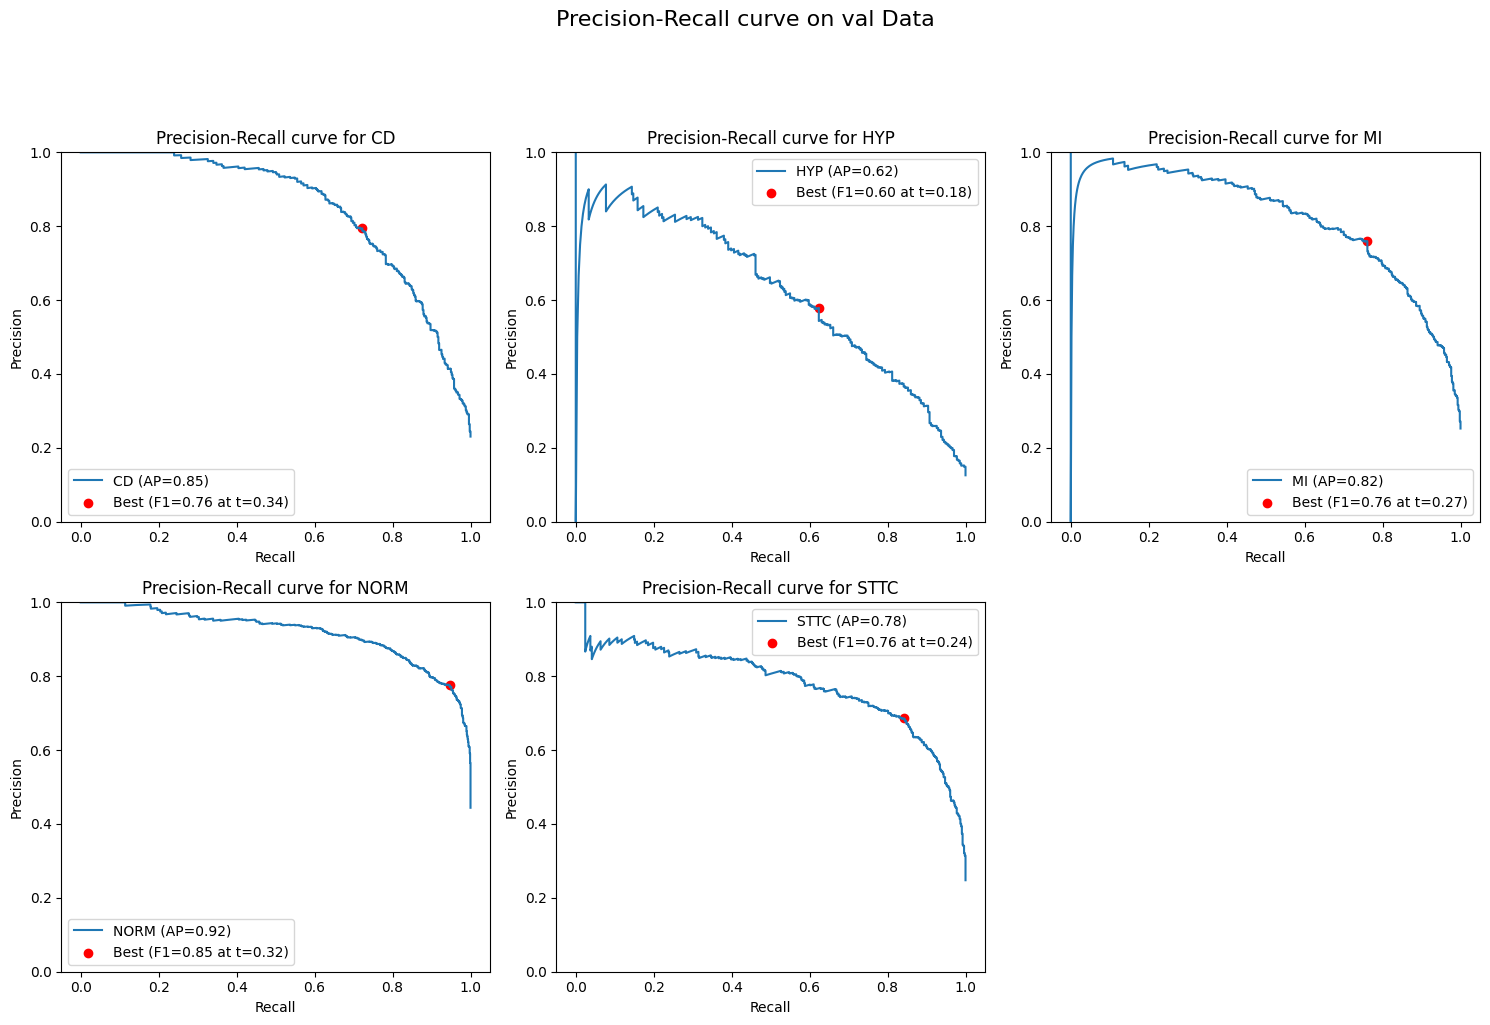

In [17]:
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Specify the folder containing the PNG images
folder_path = 'experiments/results/'
experiment_name = '2024_08_09/11_27_31_FullyConvolutionalNetwork/'
experiment_folder = folder_path + experiment_name

# List all files in the specified folder
files = os.listdir(experiment_folder)

# Filter out only PNG files
png_files = [file for file in files if file.endswith('.png')]

# Plot each PNG image
for png_file in png_files:
    img_path = os.path.join(experiment_folder, png_file)
    print('File name:', png_file)
    display(Image(filename=img_path))


Comments on the results of a *FullyConvolutionalNetwork (FCN)* trained on th ECG data as provided.

**Losses**

From the plotsof the loss functions we can see that the model improved consistently during the first 19 epochs, where the validation loss decreased and hit its lowest at epoch 22. However, after epoch 22, the model's performance plateaued, and the validation loss began to stabilize, triggering the early stopping mechanism at epoch 32 (the epochs were 50 as input). The value of the `val loss` does not have the same magnitude as the `train loss` due to the augmentation applied to the training data.

**Accuracy**: 

The overall accuracy of the model was 59.4% on validation set and 60% on test set. While this might seem moderate, other metrics suggest more nuanced performance. 

**Confusion matrices: Precision, Recall and F1-score**:

In summary, the precision-recall curves for these classes reveal that the model performs best for NORM with high precision and recall, while other classes like HYP show room for improvement. The PR curves help visualize these trade-offs and can guide adjustments in model thresholds or further refinement in model performance for specific classes.

For validation data we obtained:

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| CD    | 0.79      | 0.72   | 0.76     | 497     |
| HYP   | 0.58      | 0.62   | 0.60     | 271     |
| MI    | 0.76      | 0.76   | 0.76     | 544     |
| NORM  | 0.78      | 0.95   | 0.85     | 957     |
| STTC  | 0.69      | 0.84   | 0.76     | 534     |
| **Micro Avg**   | 0.74      | 0.82   | 0.78     | 2803    |
| **Macro Avg**   | 0.72      | 0.78   | 0.74     | 2803    |
| **Weighted Avg**| 0.74      | 0.82   | 0.77     | 2803    |
| **Samples Avg** | 0.78      | 0.84   | 0.79     | 2803    |


- `Normal (NORM)`: The model performed best on this class, with a precision of 0.78, recall of 0.95, and F1-score of 0.85, suggesting it was very accurate at identifying normal ECGs.
- `Myocardial Infarction (MI)`: Good performance with a balanced precision and recall, both at 0.76.
- `Conduction Disturbance (CD)`: Also performed well, with a precision of 0.79 and recall of 0.72.
- `Hypertrophy (HYP)`: This class had the lowest performance metrics, with a precision of 0.58 and recall of 0.62.
- `ST-T Changes (STTC)`: The model did reasonably well with a precision of 0.69 and recall of 0.84.

For the test data we obtained:

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| CD    | 0.80      | 0.74   | 0.77     | 497     |
| HYP   | 0.57      | 0.67   | 0.61     | 271     |
| MI    | 0.73      | 0.77   | 0.75     | 544     |
| NORM  | 0.80      | 0.92   | 0.86     | 957     |
| STTC  | 0.70      | 0.78   | 0.74     | 534     |
| **Micro Avg**   | 0.74      | 0.81   | 0.77     | 2803    |
| **Macro Avg**   | 0.72      | 0.78   | 0.75     | 2803    |
| **Weighted Avg**| 0.75      | 0.81   | 0.77     | 2803    |
| **Samples Avg** | 0.77      | 0.82   | 0.77     | 2803    |

It seems that the model has similar performances on validation and test data ensuring a good generalization of the model capabilities.

**Overall Conclusion**

The FullyConnected Convolutional Network demonstrated good performance across most ECG classification categories, particularly in detecting normal ECGs and myocardial infarction. However, there is room for improvement in classifying hypertrophy and ST-T changes. The model's high recall suggests it is good at identifying positive cases, but the lower precision in some categories indicates a higher number of false positives. On the other hand, low accuracy usually suggest that the model is particularly effective at identifying the positive class (in terms of recall and precision) but struggles with overall performance due to a high rate of errors in predictions, often related to the majority class or imbalanced data distribution (this experiments does not leverage undersampling or oversampling). Further tuning of the model parameters or architecture might help improve these areas.

## Conclusion

Embarking on the task of implementing a machine learning classification model for ECG signals has been a highly engaging and educational experience. Here’s an in-depth overview of how I approached this challenge, including the decisions made within the time constraints and the valuable insights gained:

- **Understanding the Problem (20% of Time):**  
  I started by dedicating a significant portion of time to understanding ECG signals, a domain new to me. This initial phase involved researching existing literature and guidelines to grasp the core concepts and challenges. Key references that guided my understanding included:
  - [PhysioNet PTB-XL Database](https://physionet.org/content/ptb-xl/1.0.2/) for foundational knowledge and dataset details.
  - [GitHub Repository by Roios](https://github.com/Roios/ptb_ecg_classification/tree/main) for implementation insights and practical approaches.
  - [Automated ECG Interpretation Repository](https://github.com/AutoECG/Automated-ECG-Interpretation) for advanced modeling techniques and benchmarks.

  This exploration provided a solid foundation and highlighted the complexity and potential of ECG data in enhancing diagnostic accuracy.

- **Exploratory Data Analysis (EDA) (30% of Time):**  
  Data exploration was a crucial and revealing phase. I utilized insights from all three references to thoroughly analyze the ECG signals. This involved visualizing the data, examining its distribution, and identifying key features and anomalies. Combining techniques from [Reference 1](https://physionet.org/content/ptb-xl/1.0.2/), [Reference 2](https://github.com/Roios/ptb_ecg_classification/tree/main), and [Reference 3](https://github.com/AutoECG/Automated-ECG-Interpretation) allowed for a comprehensive understanding of the dataset and informed subsequent preprocessing steps.

- **Project Structure and Decision-Making (15% of Time):**  
  For the project structure, I followed the guidelines from [Reference 2](https://github.com/Roios/ptb_ecg_classification/tree/main) due to its straightforward and implementable nature within the given time frame. Although [Reference 3](https://github.com/AutoECG/Automated-ECG-Interpretation) offered advanced models such as the Inception1D network with impressive performance, the goal was not to provide the best possible solution but to develop a functional and demonstrative model. Future enhancements could include implementing more sophisticated architectures like those suggested in [Reference 3](https://github.com/AutoECG/Automated-ECG-Interpretation).

- **Implementation and Documentation (25% of Time):**  
  I designed a detailed Jupyter Notebook to document the process of EDA, model training, and evaluation. This notebook serves as a comprehensive record of the methodologies and decisions made throughout the project. While I typically prefer command-line scripts, the notebook provided a transparent and accessible way to present the work. The code includes functions that are explained with detailed descriptions of their arguments and return values, and references are provided for further context.

- **Experiment Management and Future Work (10% of Time):**  
  Experiments were organized and saved locally, with plans to integrate tools like MLflow or W&B for more interactive and intuitive experiment tracking in future projects. These tools will enhance the ability to compare and analyze experiments effectively. Future improvements will include:
  - Generalizing the Pipeline class
  - Adding a variety of model architectures
  - Implementing test (pyunit, pytest) for continuous integration
  - Developing a more comprehensive benchmarking setup for comparing multiple models
  - Including function documentation as libraries with descriptions, arguments, and return values

### Insights and Learnings

Working with ECG data has been both challenging and illuminating. I gained a deeper understanding of the complexity of cardiac signals and their importance in medical diagnostics. The project highlighted the delicate balance between model complexity and practical constraints, emphasizing the need for informed decision-making based on available time and resources.

In summary, this project demonstrated my ability to make effective decisions and manage tasks within time constraints. The experience was both rewarding and educational, providing valuable lessons in data science, project management, and machine learning applications in healthcare. I am excited about the potential for future advancements and look forward to continue and expand upon these learnings.

